In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from entsoe import EntsoeRawClient
from entsoe import EntsoePandasClient
from sklearn.metrics import mean_absolute_error,mean_squared_error

#pd.set_option('display.max_rows', None)

## Provider 1

In [2]:
def preprocess_inputs_provider1(df):

    df['datetime_from'] = pd.to_datetime(df['datetime_from'],utc=True)
    df = df.set_index('datetime_from')
    df = df.drop('Unnamed: 0',axis=1)
    df = df.loc['2024-01-01 00:00:00':'2024-08-31 23:00:00']
    df.columns = ['Provider 1']
    df.index.freq = '60min'
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek + 1
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x>=6 else 0)
    df['quarter'] = df['month'].apply(lambda x : 2 if x>=5 else 1 )
    

    return df

provider1_GR = preprocess_inputs_provider1(pd.read_csv('provider1_GR.csv'))
provider1_BG = preprocess_inputs_provider1(pd.read_csv('provider1_BG.csv'))
provider1_ITSUD = preprocess_inputs_provider1(pd.read_csv('provider1_ITSUD.csv'))
provider1_RO = preprocess_inputs_provider1(pd.read_csv('provider1_RO.csv'))

## Provider 2

In [3]:
def preprocess_inputs_provider2(df):

    df = df.drop('Unnamed: 0',axis=1)
    df['datetime_from'] = pd.to_datetime(df['datetime_from'],utc=True)
    df = df.set_index('datetime_from')
    df.columns = ['Provider 2']
    df = df.loc['2024-01-01 00:00:00':'2024-08-31 23:00:00']
    df.index.freq = '60min'

    return df

provider2_GR = preprocess_inputs_provider2(pd.read_csv('provider2_GR.csv'))
provider2_BG = preprocess_inputs_provider2(pd.read_csv('provider2_BG.csv'))
provider2_ITSUD = preprocess_inputs_provider2(pd.read_csv('provider2_ITSUD.csv'))
provider2_RO = preprocess_inputs_provider2(pd.read_csv('provider2_RO.csv'))

## Provider 3

In [4]:
def preprocess_inputs_provider3(df):

    df = df.drop('Unnamed: 0',axis=1)
    df['datetime_from'] = pd.to_datetime(df['datetime_from'],utc=True)
    df = df.set_index('datetime_from')
    df.columns = ['Provider 3']
    df = df.loc['2024-01-01 00:00:00':'2024-08-31 23:00:00']
    df.index.freq = '60min'

    return df
        
provider3_GR = preprocess_inputs_provider3(pd.read_csv('provider3_GR.csv'))
provider3_BG = preprocess_inputs_provider3(pd.read_csv('provider3_BG.csv'))
provider3_ITSUD = preprocess_inputs_provider3(pd.read_csv('provider3_ITSUD.csv'))
provider3_RO = preprocess_inputs_provider3(pd.read_csv('provider3_RO.csv'))


## API

In [5]:
api_key = '7ffe7db0-e2dd-4670-97fc-a8d4cd606c29'

client = EntsoePandasClient(api_key=api_key)

countries = {'Greece': '10YGR-HTSO-----Y',
             'Bulgaria': '10YCA-BULGARIA-R',
             'Romania': '10YRO-TEL------P' ,
             'Italy' : '10Y1001A1001A788'
            }

start = pd.Timestamp('20240101', tz='Europe/Athens')
end = pd.Timestamp('20240902', tz='Europe/Athens')


country_dataframes = {}

for country, country_code in countries.items():
    try:
        data = client.query_day_ahead_prices(country_code, start=start, end=end)
        print(f"Market data for {country}:")


        df = pd.DataFrame(data)


        country_dataframes[country] = df

        print(df)  

    except Exception as e:
        print(f"Error fetching data for {country}: {e}")



Market data for Greece:
                                0
2024-01-01 00:00:00+02:00  106.12
2024-01-01 01:00:00+02:00  107.09
2024-01-01 02:00:00+02:00  104.00
2024-01-01 03:00:00+02:00  100.00
2024-01-01 04:00:00+02:00   85.66
...                           ...
2024-09-01 20:00:00+03:00  230.88
2024-09-01 21:00:00+03:00  242.85
2024-09-01 22:00:00+03:00  223.36
2024-09-01 23:00:00+03:00  157.61
2024-09-02 00:00:00+03:00  140.86

[5880 rows x 1 columns]
Market data for Bulgaria:
                                0
2024-01-01 00:00:00+02:00   14.95
2024-01-01 01:00:00+02:00    0.10
2024-01-01 02:00:00+02:00    0.01
2024-01-01 03:00:00+02:00    0.04
2024-01-01 04:00:00+02:00    0.01
...                           ...
2024-09-01 20:00:00+03:00  230.88
2024-09-01 21:00:00+03:00  242.85
2024-09-01 22:00:00+03:00  223.36
2024-09-01 23:00:00+03:00  157.61
2024-09-02 00:00:00+03:00  140.86

[5880 rows x 1 columns]
Market data for Romania:
                                0
2024-01-01 00:00:00+02:00

In [6]:
def preprocess_api(value):

    actual_country = pd.DataFrame(value)
    actual_country.columns = ['True value']
    actual_country.index = pd.to_datetime(actual_country.index,utc=True)
    actual_country = actual_country['2024-01-01 00:00:00+00:00':'2024-08-31 23:00:00+00:00']

    
    return actual_country

actual_bulgaria = preprocess_api(country_dataframes['Bulgaria'])
actual_greece = preprocess_api(country_dataframes['Greece'])
actual_romania = preprocess_api(country_dataframes['Romania'])
actual_italy = preprocess_api(country_dataframes['Italy'])

## Concatenate each country

In [7]:
greece = pd.concat([provider1_GR,provider2_GR,provider3_GR,actual_greece],axis=1)
greece = greece[['Provider 1','Provider 2','Provider 3','True value','hour','dayofweek','month','is_weekend','quarter']]

bulgaria = pd.concat([provider1_BG,provider2_BG,provider3_BG,actual_bulgaria],axis=1)
bulgaria = bulgaria[['Provider 1','Provider 2','Provider 3','True value','hour','dayofweek','month','is_weekend','quarter']]

romania = pd.concat([provider1_RO,provider2_RO,provider3_RO,actual_romania],axis=1)
romania = romania[['Provider 1','Provider 2','Provider 3','True value','hour','dayofweek','month','is_weekend','quarter']]

italy = pd.concat([provider1_ITSUD,provider2_ITSUD,provider3_ITSUD,actual_italy],axis=1)
italy = italy[['Provider 1','Provider 2','Provider 3','True value','hour','dayofweek','month','is_weekend','quarter']]


In [8]:
greece.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Provider 1,5856.0,92.508542,52.400415,0.000000,67.027500,86.370000,107.342500,582.920000
Provider 2,5856.0,94.222032,57.863933,-7.990000,67.467500,85.915000,107.757500,663.310000
Provider 3,5856.0,87.539149,52.893780,0.001961,64.694706,79.121176,99.900833,828.260196
True value,5856.0,92.673403,61.287521,-1.020000,68.180000,86.255000,106.820000,850.000000
hour,5856.0,11.500000,6.922778,0.000000,5.750000,11.500000,17.250000,23.000000
dayofweek,5856.0,3.987705,1.995003,1.000000,2.000000,4.000000,6.000000,7.000000
month,5856.0,4.516393,2.296785,1.000000,3.000000,5.000000,7.000000,8.000000
is_weekend,5856.0,0.282787,0.450392,0.000000,0.000000,0.000000,1.000000,1.000000
quarter,5856.0,1.504098,0.500026,1.000000,1.000000,2.000000,2.000000,2.000000


In [9]:
italy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Provider 1,5856.0,101.917500,27.984101,0.010000,85.80750,101.630000,116.240000,232.950000
Provider 2,5856.0,100.272608,28.517184,-6.660000,84.29500,99.810000,113.242500,248.180000
Provider 3,5856.0,97.881668,26.611979,12.873725,81.48951,96.714804,111.672598,259.406275
True value,5856.0,101.173731,30.261255,0.000000,86.59750,100.445000,114.385000,249.860000
hour,5856.0,11.500000,6.922778,0.000000,5.75000,11.500000,17.250000,23.000000
dayofweek,5856.0,3.987705,1.995003,1.000000,2.00000,4.000000,6.000000,7.000000
month,5856.0,4.516393,2.296785,1.000000,3.00000,5.000000,7.000000,8.000000
is_weekend,5856.0,0.282787,0.450392,0.000000,0.00000,0.000000,1.000000,1.000000
quarter,5856.0,1.504098,0.500026,1.000000,1.00000,2.000000,2.000000,2.000000


In [10]:
romania.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Provider 1,5856.0,91.717833,64.823930,-0.640000,61.090000,83.990000,107.660000,759.770000
Provider 2,5856.0,94.542544,82.335133,-24.040000,62.022500,83.315000,108.042500,1591.590000
Provider 3,5856.0,83.211501,55.995499,-16.999216,57.407402,76.174314,97.791176,828.253137
True value,5856.0,91.856460,73.803253,-106.360000,61.497500,84.005000,106.852500,916.720000
hour,5856.0,11.500000,6.922778,0.000000,5.750000,11.500000,17.250000,23.000000
dayofweek,5856.0,3.987705,1.995003,1.000000,2.000000,4.000000,6.000000,7.000000
month,5856.0,4.516393,2.296785,1.000000,3.000000,5.000000,7.000000,8.000000
is_weekend,5856.0,0.282787,0.450392,0.000000,0.000000,0.000000,1.000000,1.000000
quarter,5856.0,1.504098,0.500026,1.000000,1.000000,2.000000,2.000000,2.000000


In [11]:
bulgaria.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Provider 1,5856.0,176.330555,118.006521,-33.540000,117.075000,163.760000,208.410000,1400.33000
Provider 2,5856.0,91.097462,61.456670,-11.350000,61.995000,82.895000,106.842500,737.43000
Provider 3,5856.0,83.292579,55.775872,-4.501373,57.607598,76.222941,97.725833,828.25098
True value,5856.0,90.856047,69.623590,-45.000000,61.385000,84.115000,106.282500,879.46000
hour,5856.0,11.500000,6.922778,0.000000,5.750000,11.500000,17.250000,23.00000
dayofweek,5856.0,3.987705,1.995003,1.000000,2.000000,4.000000,6.000000,7.00000
month,5856.0,4.516393,2.296785,1.000000,3.000000,5.000000,7.000000,8.00000
is_weekend,5856.0,0.282787,0.450392,0.000000,0.000000,0.000000,1.000000,1.00000
quarter,5856.0,1.504098,0.500026,1.000000,1.000000,2.000000,2.000000,2.00000


## EDA for each provider for each country [Average-prices]

In [12]:
greece_hour_mean = greece.groupby('hour').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
italy_hour_mean = italy.groupby('hour').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
romania_hour_mean = romania.groupby('hour').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
bulgaria_hour_mean = bulgaria.groupby('hour').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]

### Provider 1

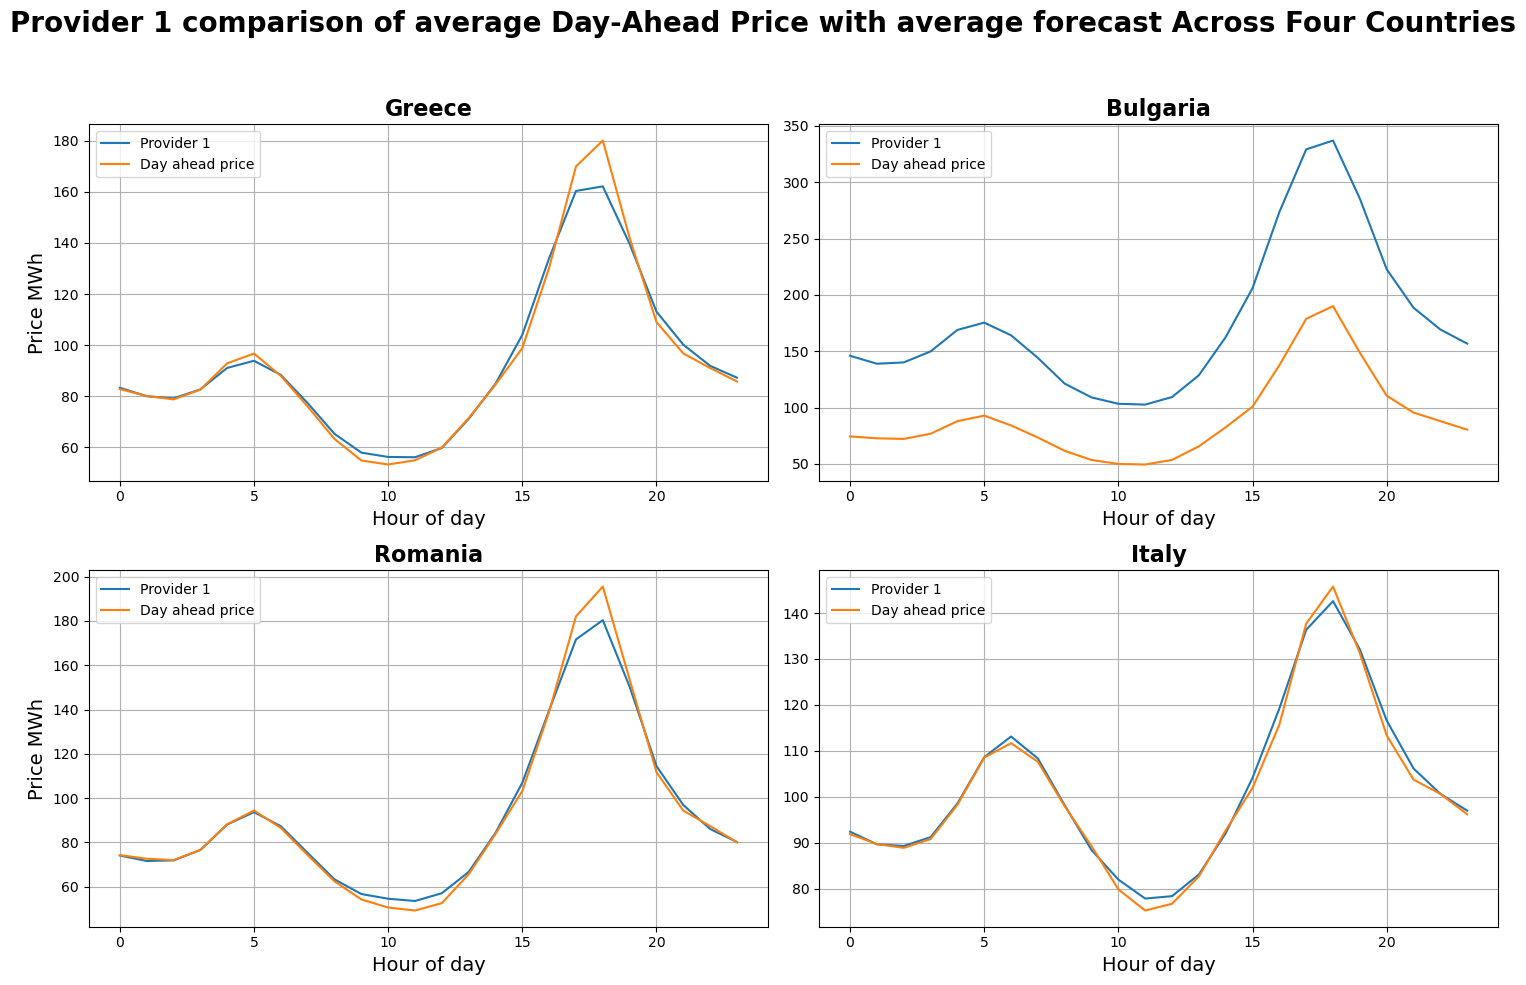

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Στυλ γραμματοσειράς
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Histogram για την Ελλάδα
axes[0][0].plot(greece_hour_mean['Provider 1'],label=['Provider 1'])
axes[0][0].plot(greece_hour_mean['True value'],label=['Day ahead price'])
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('Price MWh', **label_font)
axes[0][0].legend()
axes[0][0].grid(True)

axes[1][1].plot(italy_hour_mean['Provider 1'],label=['Provider 1'])
axes[1][1].plot(italy_hour_mean['True value'],label=['Day ahead price'])
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
#axes[1][1].set_ylabel('Price MWh', **label_font)
axes[1][1].legend()
axes[1][1].grid(True)


axes[1][0].plot(romania_hour_mean['Provider 1'],label=['Provider 1'])
axes[1][0].plot(romania_hour_mean['True value'],label=['Day ahead price'])
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('Price MWh', **label_font)
axes[1][0].legend()
axes[1][0].grid(True)


axes[0][1].plot(bulgaria_hour_mean['Provider 1'],label=['Provider 1'])
axes[0][1].plot(bulgaria_hour_mean['True value'],label=['Day ahead price'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].set_xlabel('Hour of day', **label_font)
#axes[0][1].set_ylabel('Price MWh', **label_font)
axes[0][1].legend()
axes[0][1].grid(True)

# Προσαρμογή του layout

fig.suptitle('Provider 1 comparison of average Day-Ahead Price with average forecast Across Four Countries', fontsize=20, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig('Provider 1 comparison of Day-Ahead Price Across Four Countries.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα


# Εμφάνιση του γραφήματος
plt.show()

### Provider 2

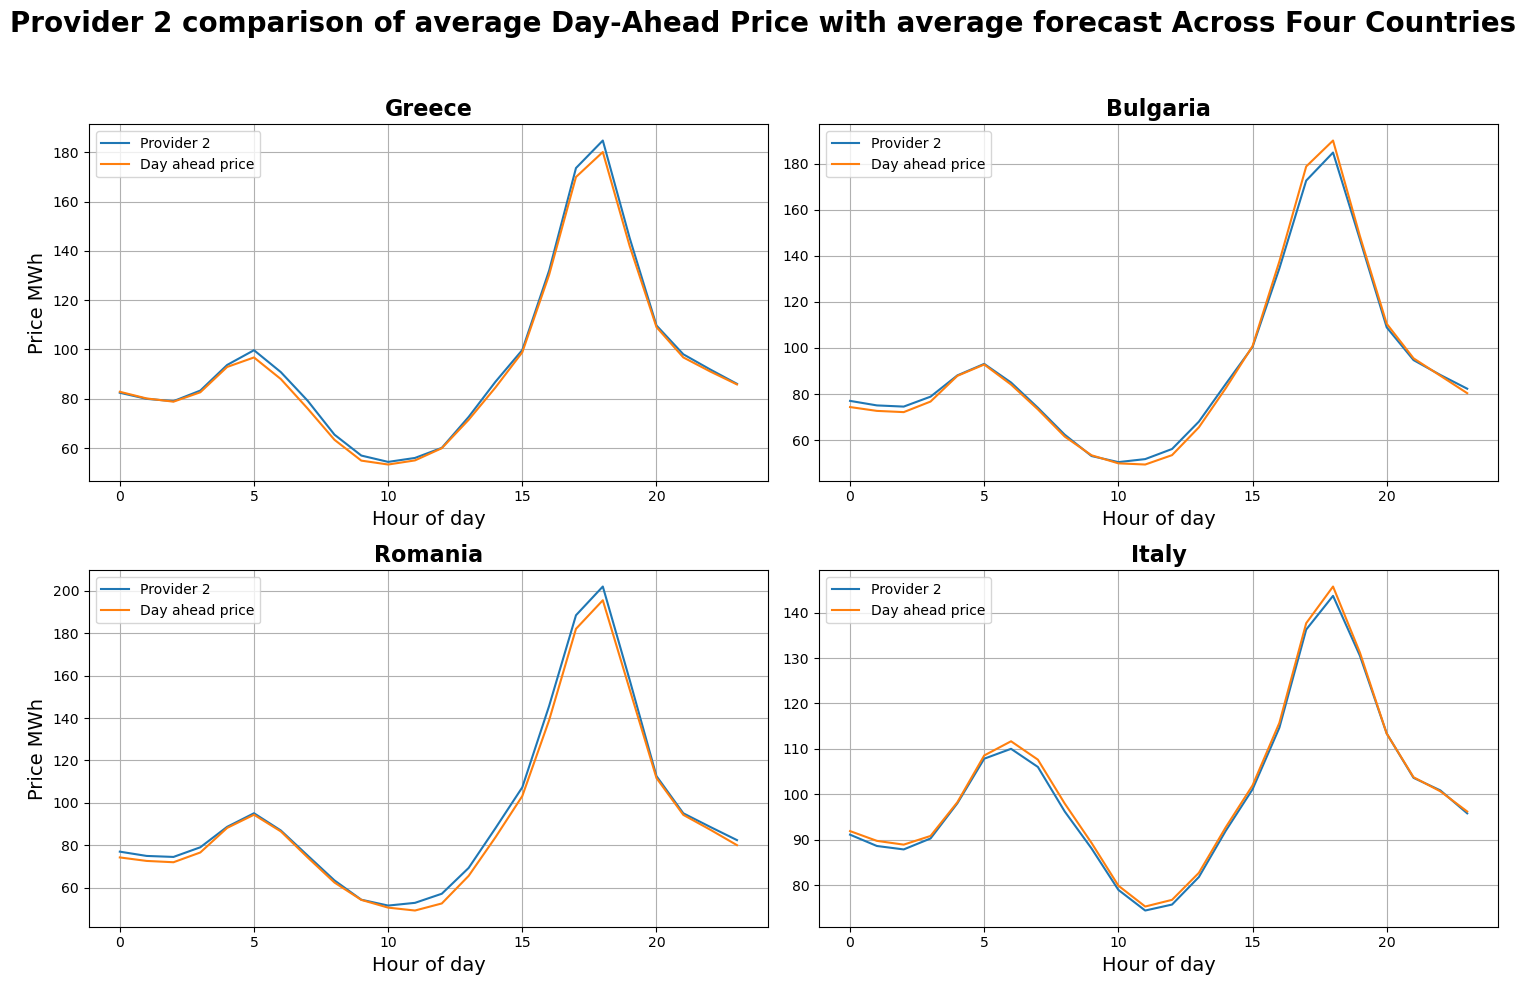

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Στυλ γραμματοσειράς
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Histogram για την Ελλάδα
axes[0][0].plot(greece_hour_mean['Provider 2'],label=['Provider 2'])
axes[0][0].plot(greece_hour_mean['True value'],label=['Day ahead price'])
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('Price MWh', **label_font)
axes[0][0].legend()
axes[0][0].grid(True)

axes[1][1].plot(italy_hour_mean['Provider 2'],label=['Provider 2'])
axes[1][1].plot(italy_hour_mean['True value'],label=['Day ahead price'])
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
#axes[1][1].set_ylabel('Price MWh', **label_font)
axes[1][1].legend()
axes[1][1].grid(True)


axes[1][0].plot(romania_hour_mean['Provider 2'],label=['Provider 2'])
axes[1][0].plot(romania_hour_mean['True value'],label=['Day ahead price'])
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('Price MWh', **label_font)
axes[1][0].legend()
axes[1][0].grid(True)


axes[0][1].plot(bulgaria_hour_mean['Provider 2'],label=['Provider 2'])
axes[0][1].plot(bulgaria_hour_mean['True value'],label=['Day ahead price'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].set_xlabel('Hour of day', **label_font)
#axes[0][1].set_ylabel('Price MWh', **label_font)
axes[0][1].legend()
axes[0][1].grid(True)

# Προσαρμογή του layout

fig.suptitle('Provider 2 comparison of average Day-Ahead Price with average forecast Across Four Countries', fontsize=20, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig('Provider 2 comparison of Day-Ahead Price Across Four Countries.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα


# Εμφάνιση του γραφήματος
plt.show()

### Provider 3

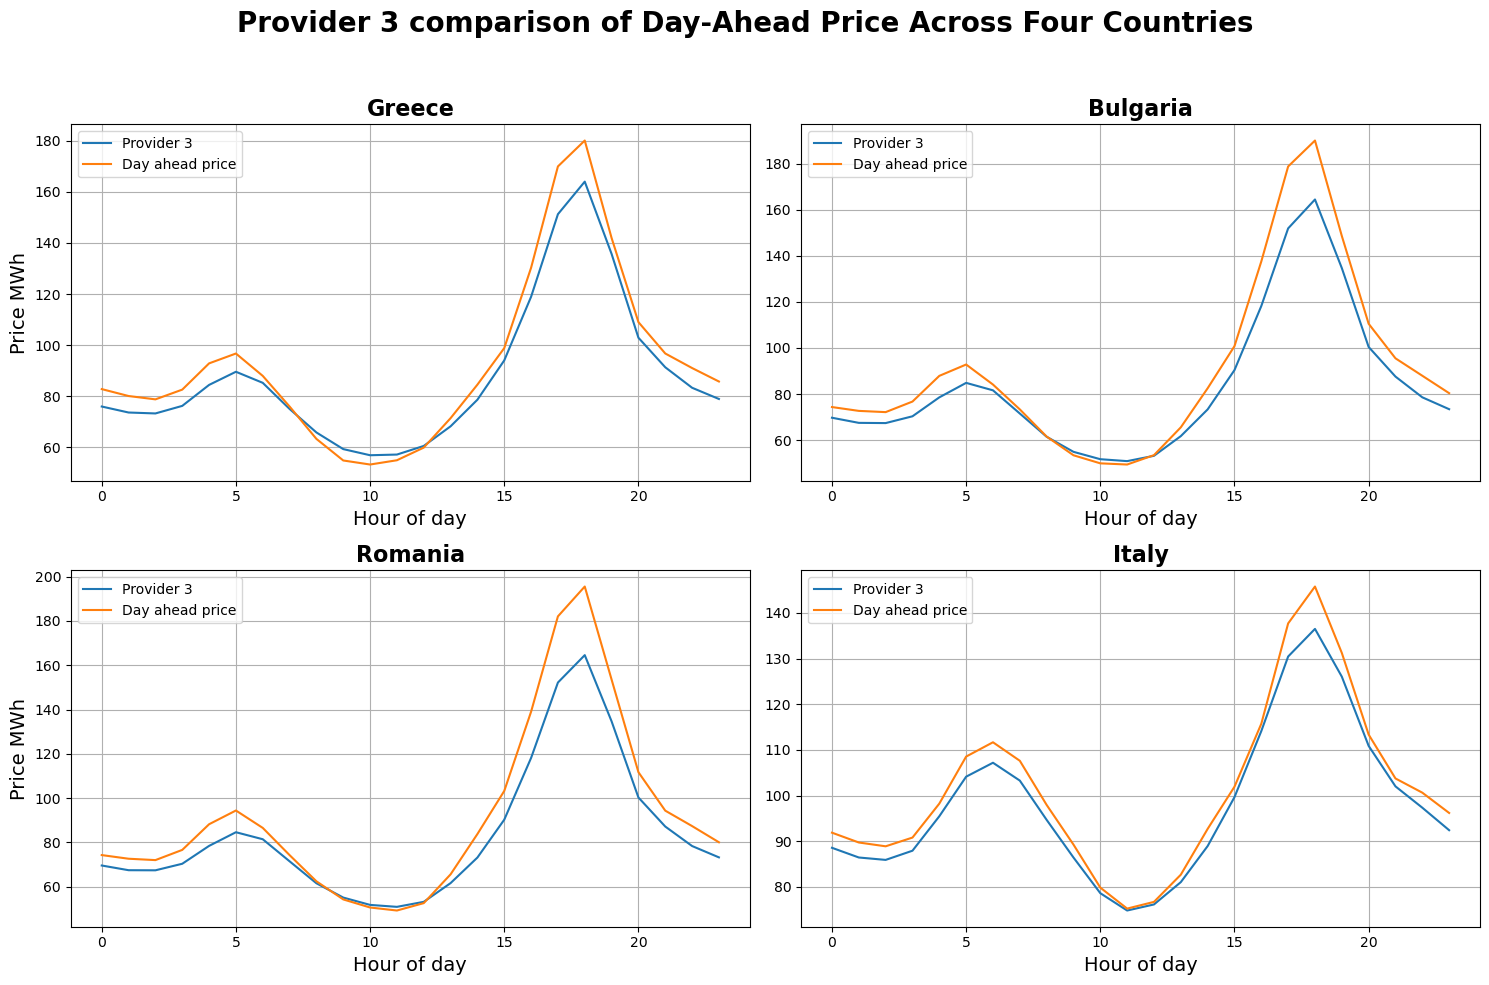

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Στυλ γραμματοσειράς
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Histogram για την Ελλάδα
axes[0][0].plot(greece_hour_mean['Provider 3'],label=['Provider 3'])
axes[0][0].plot(greece_hour_mean['True value'],label=['Day ahead price'])
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('Price MWh', **label_font)
axes[0][0].legend()
axes[0][0].grid(True)

axes[1][1].plot(italy_hour_mean['Provider 3'],label=['Provider 3'])
axes[1][1].plot(italy_hour_mean['True value'],label=['Day ahead price'])
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
#axes[1][1].set_ylabel('Price MWh', **label_font)
axes[1][1].legend()
axes[1][1].grid(True)


axes[1][0].plot(romania_hour_mean['Provider 3'],label=['Provider 3'])
axes[1][0].plot(romania_hour_mean['True value'],label=['Day ahead price'])
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('Price MWh', **label_font)
axes[1][0].legend()
axes[1][0].grid(True)


axes[0][1].plot(bulgaria_hour_mean['Provider 3'],label=['Provider 3'])
axes[0][1].plot(bulgaria_hour_mean['True value'],label=['Day ahead price'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].set_xlabel('Hour of day', **label_font)
#axes[0][1].set_ylabel('Price MWh', **label_font)
axes[0][1].legend()
axes[0][1].grid(True)

# Προσαρμογή του layout

fig.suptitle('Provider 3 comparison of Day-Ahead Price Across Four Countries', fontsize=20, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig('Provider 3 comparison of Day-Ahead Price Across Four Countries.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα


# Εμφάνιση του γραφήματος
plt.show()

## Calculating MAE for each provider for each country

### Provider 1

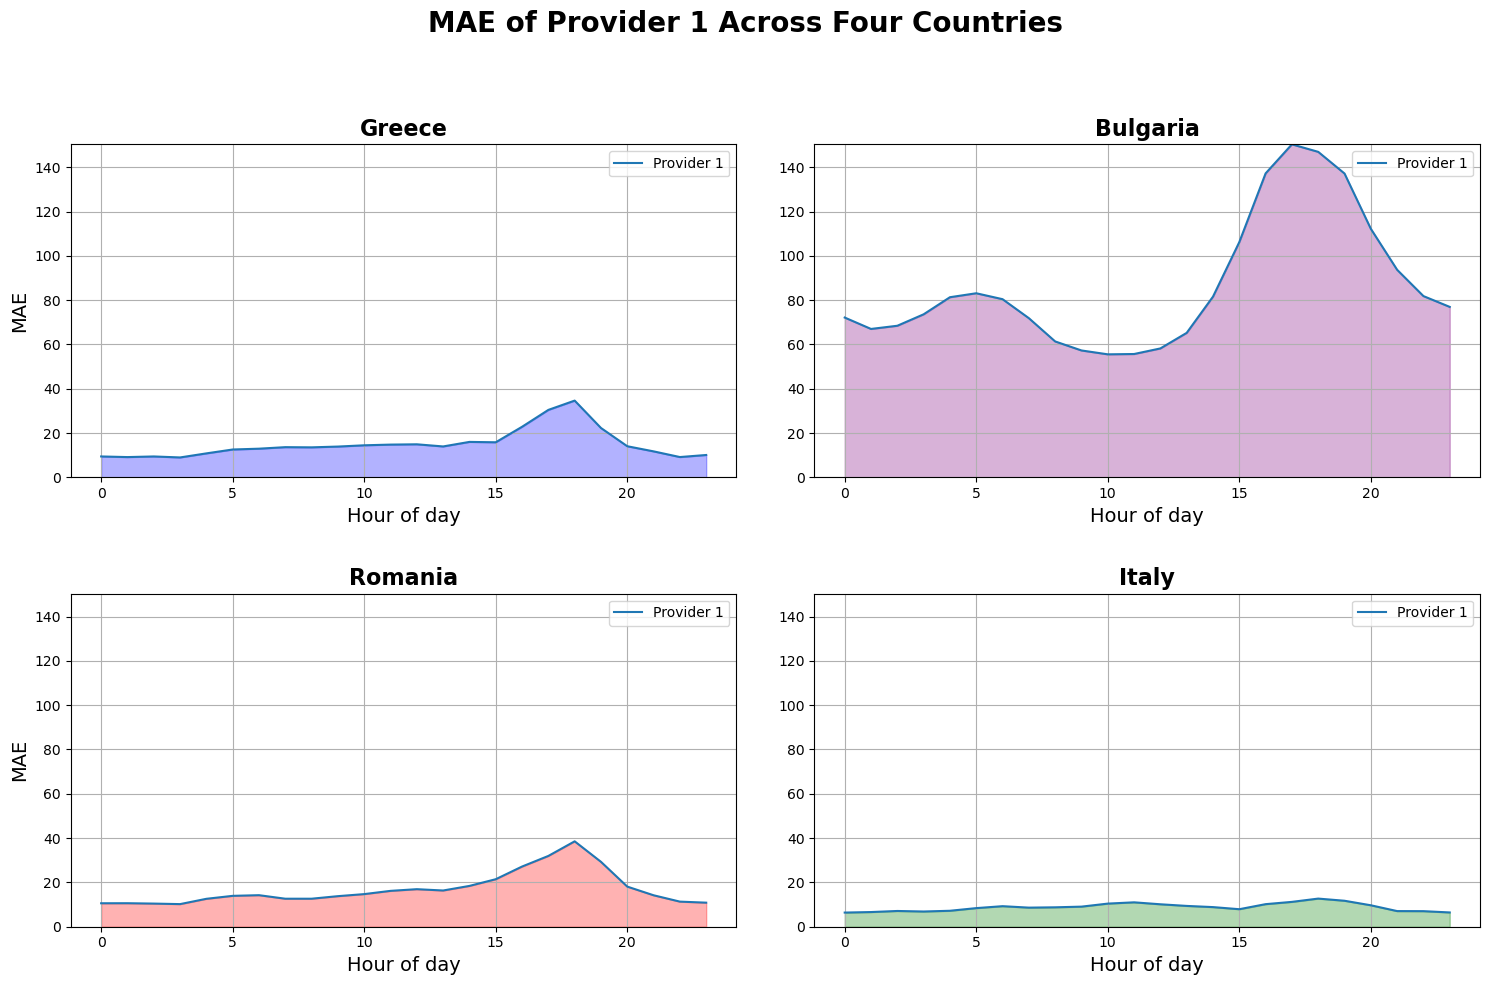

In [16]:
mae_per_hour_greece_provider1 = {}
mae_per_hour_bulgaria_provider1 = {}
mae_per_hour_italy_provider1 = {}
mae_per_hour_romania_provider1 = {}

for i in range(24):

    mae_per_hour_greece_provider1[i] = abs(greece [ greece['hour'] == i]['Provider 1'] - greece [ greece['hour'] == i]['True value']).mean()
    mae_per_hour_bulgaria_provider1[i] = abs(bulgaria [ bulgaria['hour'] == i]['Provider 1'] - bulgaria [ bulgaria['hour'] == i]['True value']).mean()
    mae_per_hour_italy_provider1[i] = abs(italy [ italy['hour'] == i]['Provider 1'] - italy [ italy['hour'] == i]['True value']).mean()
    mae_per_hour_romania_provider1[i] = abs(romania [ romania['hour'] == i]['Provider 1'] - romania [ romania['hour'] == i]['True value']).mean()


mae_per_hour_greece_provider1 = pd.Series(mae_per_hour_greece_provider1)
mae_per_hour_greece_provider1.index.name = 'hour'

mae_per_hour_bulgaria_provider1 = pd.Series(mae_per_hour_bulgaria_provider1)
mae_per_hour_bulgaria_provider1.index.name = 'hour'

mae_per_hour_italy_provider1 = pd.Series(mae_per_hour_italy_provider1)
mae_per_hour_italy_provider1.index.name = 'hour'

mae_per_hour_romania_provider1 = pd.Series(mae_per_hour_romania_provider1)
mae_per_hour_romania_provider1.index.name = 'hour'

#Finding max value
max_value = 0

mae_per_hour_all_provider1 = [mae_per_hour_greece_provider1,
                              mae_per_hour_bulgaria_provider1,
                              mae_per_hour_italy_provider1,
                              mae_per_hour_romania_provider1]

for dictionary in mae_per_hour_all_provider1:
    for key,value in dictionary.items():

        if value > max_value:
            max_value = value

# Plot the data in a similar style as requested
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Font styles
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Subplot 1: Greece
axes[0][0].plot(mae_per_hour_greece_provider1, label=['Provider 1'])
axes[0][0].fill_between(mae_per_hour_greece_provider1.index, mae_per_hour_greece_provider1, color='blue', alpha=0.3)
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('MAE', **label_font)
axes[0][0].legend()
axes[0][0].set_ylim(0, max_value)
axes[0][0].grid(True)

# Subplot 2: Italy
axes[1][1].plot(mae_per_hour_italy_provider1, label=['Provider 1'])
axes[1][1].fill_between(mae_per_hour_italy_provider1.index, mae_per_hour_italy_provider1, color='green', alpha=0.3)
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
axes[1][1].legend()
axes[1][1].set_ylim(0, max_value)
axes[1][1].grid(True)

# Subplot 3: Romania
axes[1][0].plot(mae_per_hour_romania_provider1, label=['Provider 1'])
axes[1][0].fill_between(mae_per_hour_romania_provider1.index, mae_per_hour_romania_provider1, color='red', alpha=0.3)
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('MAE', **label_font)
axes[1][0].legend()
axes[1][0].set_ylim(0, max_value)
axes[1][0].grid(True)

# Subplot 4: Bulgaria
axes[0][1].plot(mae_per_hour_bulgaria_provider1, label=['Provider 1'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].fill_between(mae_per_hour_bulgaria_provider1.index, mae_per_hour_bulgaria_provider1, color='purple', alpha=0.3)
axes[0][1].set_xlabel('Hour of day', **label_font)
axes[0][1].legend()
axes[0][1].set_ylim(0, max_value)
axes[0][1].grid(True)

# Overall title
fig.suptitle('MAE of Provider 1 Across Four Countries', fontsize=20, fontweight='bold')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=3.0, w_pad=3.0)

# Show the plot
plt.show()

### Provider 2

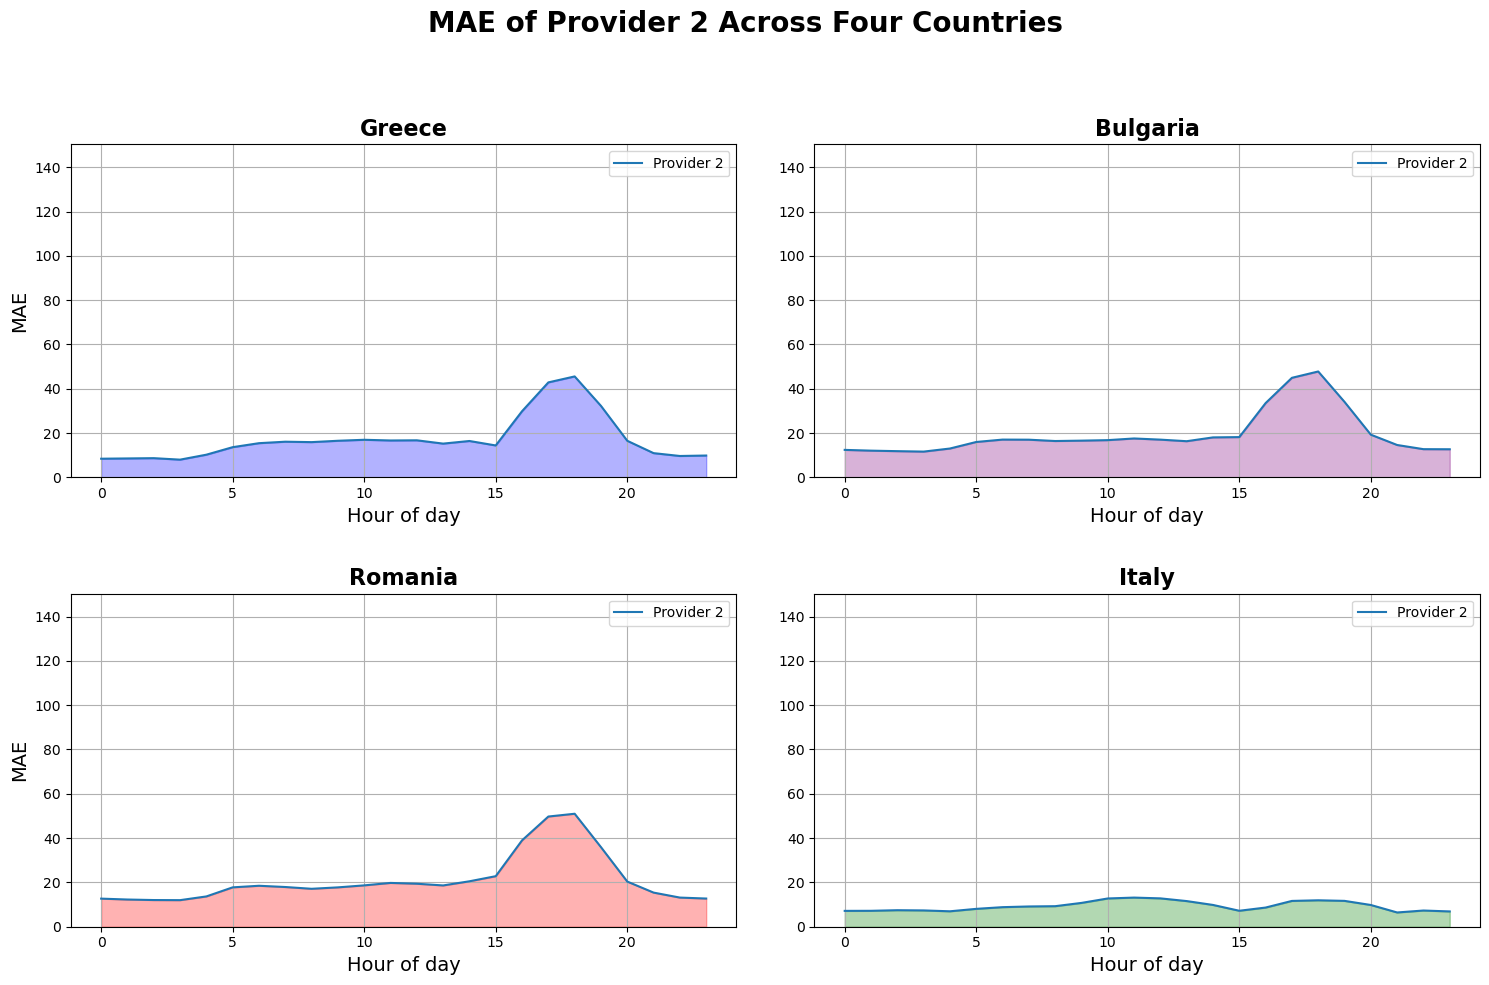

In [17]:
mae_per_hour_greece_provider2 = {}
mae_per_hour_bulgaria_provider2 = {}
mae_per_hour_italy_provider2 = {}
mae_per_hour_romania_provider2 = {}

for i in range(24):

    mae_per_hour_greece_provider2[i] = abs(greece [ greece['hour'] == i]['Provider 2'] - greece [ greece['hour'] == i]['True value']).mean()
    mae_per_hour_bulgaria_provider2[i] = abs(bulgaria [ bulgaria['hour'] == i]['Provider 2'] - bulgaria [ bulgaria['hour'] == i]['True value']).mean()
    mae_per_hour_italy_provider2[i] = abs(italy [ italy['hour'] == i]['Provider 2'] - italy [ italy['hour'] == i]['True value']).mean()
    mae_per_hour_romania_provider2[i] = abs(romania [ romania['hour'] == i]['Provider 2'] - romania [ romania['hour'] == i]['True value']).mean()


mae_per_hour_greece_provider2 = pd.Series(mae_per_hour_greece_provider2)
mae_per_hour_greece_provider2.index.name = 'hour'

mae_per_hour_bulgaria_provider2 = pd.Series(mae_per_hour_bulgaria_provider2)
mae_per_hour_bulgaria_provider2.index.name = 'hour'

mae_per_hour_italy_provider2 = pd.Series(mae_per_hour_italy_provider2)
mae_per_hour_italy_provider2.index.name = 'hour'

mae_per_hour_romania_provider2 = pd.Series(mae_per_hour_romania_provider2)
mae_per_hour_romania_provider2.index.name = 'hour'


# Plot the data in a similar style as requested
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Font styles
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Subplot 1: Greece
axes[0][0].plot(mae_per_hour_greece_provider2, label=['Provider 2'])
axes[0][0].fill_between(mae_per_hour_greece_provider2.index, mae_per_hour_greece_provider2, color='blue', alpha=0.3)
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('MAE', **label_font)
axes[0][0].legend()
axes[0][0].set_ylim(0, max_value)
axes[0][0].grid(True)

# Subplot 2: Italy
axes[1][1].plot(mae_per_hour_italy_provider2, label=['Provider 2'])
axes[1][1].fill_between(mae_per_hour_italy_provider2.index, mae_per_hour_italy_provider2, color='green', alpha=0.3)
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
axes[1][1].legend()
axes[1][1].set_ylim(0, max_value)
axes[1][1].grid(True)

# Subplot 3: Romania
axes[1][0].plot(mae_per_hour_romania_provider2, label=['Provider 2'])
axes[1][0].fill_between(mae_per_hour_romania_provider2.index, mae_per_hour_romania_provider2, color='red', alpha=0.3)
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('MAE', **label_font)
axes[1][0].legend()
axes[1][0].set_ylim(0, max_value)
axes[1][0].grid(True)

# Subplot 4: Bulgaria
axes[0][1].plot(mae_per_hour_bulgaria_provider2, label=['Provider 2'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].fill_between(mae_per_hour_bulgaria_provider2.index, mae_per_hour_bulgaria_provider2, color='purple', alpha=0.3)
axes[0][1].set_xlabel('Hour of day', **label_font)
axes[0][1].legend()
axes[0][1].set_ylim(0, max_value)
axes[0][1].grid(True)

# Overall title
fig.suptitle('MAE of Provider 2 Across Four Countries', fontsize=20, fontweight='bold')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=3.0, w_pad=3.0)

# Show the plot
plt.show()

### Provider 3

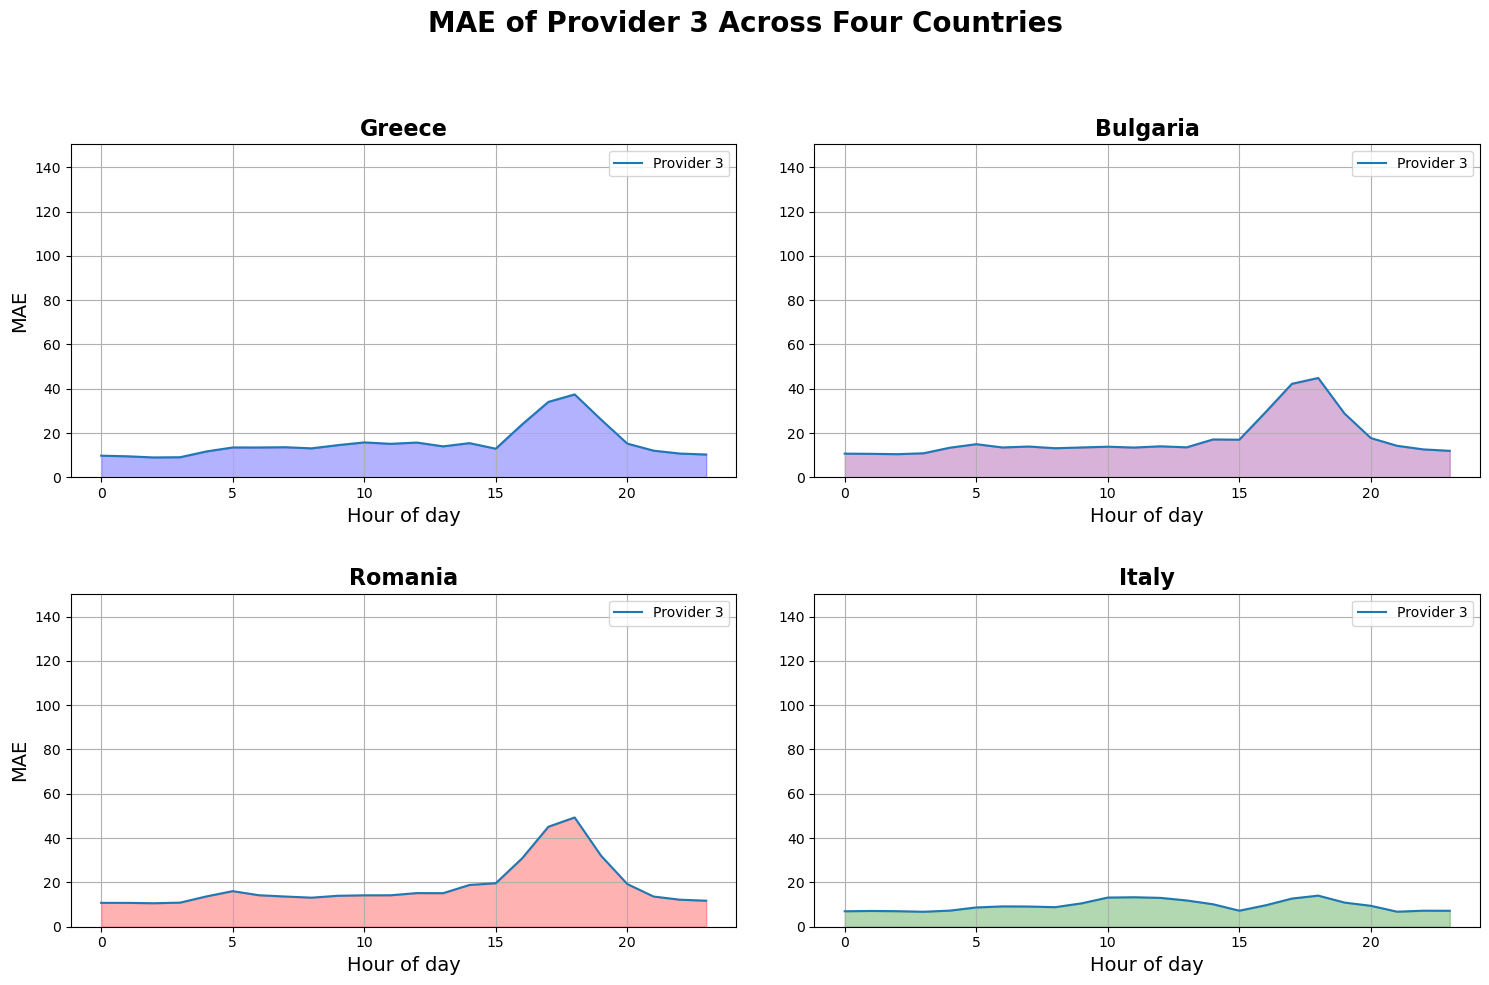

In [18]:
mae_per_hour_greece_provider3 = {}
mae_per_hour_bulgaria_provider3 = {}
mae_per_hour_italy_provider3 = {}
mae_per_hour_romania_provider3 = {}


for i in range(24):

    mae_per_hour_greece_provider3[i] = abs(greece [ greece['hour'] == i]['Provider 3'] - greece [ greece['hour'] == i]['True value']).mean()
    mae_per_hour_bulgaria_provider3[i] = abs(bulgaria [ bulgaria['hour'] == i]['Provider 3'] - bulgaria [ bulgaria['hour'] == i]['True value']).mean()
    mae_per_hour_italy_provider3[i] = abs(italy [ italy['hour'] == i]['Provider 3'] - italy [ italy['hour'] == i]['True value']).mean()
    mae_per_hour_romania_provider3[i] = abs(romania [ romania['hour'] == i]['Provider 3'] - romania [ romania['hour'] == i]['True value']).mean()


mae_per_hour_greece_provider3 = pd.Series(mae_per_hour_greece_provider3)
mae_per_hour_greece_provider3.index.name = 'hour'

mae_per_hour_bulgaria_provider3 = pd.Series(mae_per_hour_bulgaria_provider3)
mae_per_hour_bulgaria_provider3.index.name = 'hour'

mae_per_hour_italy_provider3 = pd.Series(mae_per_hour_italy_provider3)
mae_per_hour_italy_provider3.index.name = 'hour'

mae_per_hour_romania_provider3 = pd.Series(mae_per_hour_romania_provider3)
mae_per_hour_romania_provider3.index.name = 'hour'


# Plot the data in a similar style as requested
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Font styles
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Subplot 1: Greece
axes[0][0].plot(mae_per_hour_greece_provider3, label=['Provider 3'])
axes[0][0].fill_between(mae_per_hour_greece_provider3.index, mae_per_hour_greece_provider3, color='blue', alpha=0.3)
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Hour of day', **label_font)
axes[0][0].set_ylabel('MAE', **label_font)
axes[0][0].legend()
axes[0][0].set_ylim(0, max_value)
axes[0][0].grid(True)

# Subplot 2: Italy
axes[1][1].plot(mae_per_hour_italy_provider3, label=['Provider 3'])
axes[1][1].fill_between(mae_per_hour_italy_provider3.index, mae_per_hour_italy_provider3, color='green', alpha=0.3)
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Hour of day', **label_font)
axes[1][1].legend()
axes[1][1].set_ylim(0, max_value)
axes[1][1].grid(True)

# Subplot 3: Romania
axes[1][0].plot(mae_per_hour_romania_provider3, label=['Provider 3'])
axes[1][0].fill_between(mae_per_hour_romania_provider3.index, mae_per_hour_romania_provider3, color='red', alpha=0.3)
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Hour of day', **label_font)
axes[1][0].set_ylabel('MAE', **label_font)
axes[1][0].legend()
axes[1][0].set_ylim(0, max_value)
axes[1][0].grid(True)

# Subplot 4: Bulgaria
axes[0][1].plot(mae_per_hour_bulgaria_provider3, label=['Provider 3'])
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].fill_between(mae_per_hour_bulgaria_provider3.index, mae_per_hour_bulgaria_provider3, color='purple', alpha=0.3)
axes[0][1].set_xlabel('Hour of day', **label_font)
axes[0][1].legend()
axes[0][1].set_ylim(0, max_value)
axes[0][1].grid(True)

# Overall title
fig.suptitle('MAE of Provider 3 Across Four Countries', fontsize=20, fontweight='bold')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=3.0, w_pad=3.0)

# Show the plot
plt.show()

## Concatenate all countries together

In [19]:
all_countries = pd.concat([greece,italy,romania,bulgaria],axis=0)
all_countries

,Provider 1,Provider 2,Provider 3,True value,hour,dayofweek,month,is_weekend,quarter
2024-01-01 00:00:00+00:00,92.01,96.70,79.142549,104.00,0,1,1,0,1
2024-01-01 01:00:00+00:00,83.32,90.03,70.364118,100.00,1,1,1,0,1
2024-01-01 02:00:00+00:00,78.59,80.03,64.870588,85.66,2,1,1,0,1
2024-01-01 03:00:00+00:00,79.24,85.94,65.352549,85.00,3,1,1,0,1
2024-01-01 04:00:00+00:00,87.05,96.01,77.120000,85.53,4,1,1,0,1
...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00+00:00,256.94,168.92,158.940784,160.02,19,6,8,1,2
2024-08-31 20:00:00+00:00,232.07,137.68,120.525686,134.91,20,6,8,1,2
2024-08-31 21:00:00+00:00,205.45,124.73,95.619216,116.29,21,6,8,1,2
2024-08-31 22:00:00+00:00,208.84,124.53,87.077647,96.41,22,6,8,1,2


### Hour

In [20]:
hours_mean = all_countries.groupby('hour').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value','quarter']]
hours_mean

,Provider 1,Provider 2,Provider 3,True value,quarter
hour,,,,,
0,98.949549,81.894529,75.973081,80.839559,1.504098
1,95.054682,79.657828,73.770859,78.798955,1.504098
2,95.105932,78.991014,73.512347,77.974908,1.504098
3,100.059949,82.882418,76.232561,81.703463,1.504098
4,111.646301,92.137203,84.240583,91.813699,1.504098
5,117.895113,98.937059,90.805569,98.133227,1.504098
6,113.233279,93.210676,88.883547,92.588473,1.504098
7,101.255092,83.618863,80.346080,82.817777,1.504098
8,86.999641,71.869314,70.897610,71.325615,1.504098


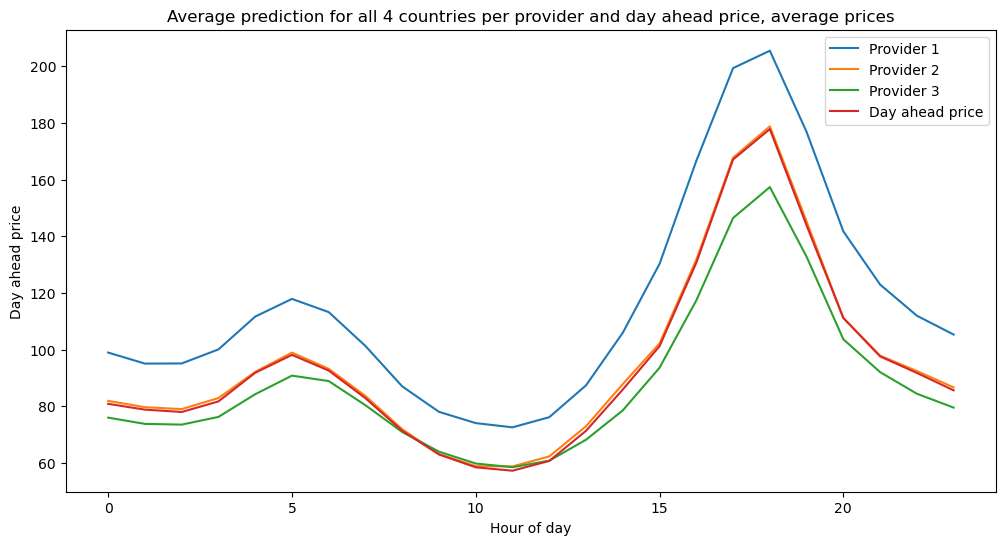

In [21]:
## We compare the average forecast for one hour with the average true value for the same hour.

plt.figure(figsize=(12,6))

plt.plot(hours_mean['Provider 1'],label='Provider 1')
plt.plot(hours_mean['Provider 2'],label='Provider 2')
plt.plot(hours_mean['Provider 3'],label='Provider 3')
plt.plot(hours_mean['True value'],label='Day ahead price')
plt.title('Average prediction for all 4 countries per provider and day ahead price, average prices')
plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('Day ahead price');

In [22]:
print(f" Provider 1 MAE on hour of day average {mean_absolute_error(hours_mean['Provider 1'],hours_mean['True value']):.2f}")
print(f" Provider 2 MAE on hour of day average {mean_absolute_error(hours_mean['Provider 2'],hours_mean['True value']):.2f}")
print(f" Provider 3 MAE on hour of day average {mean_absolute_error(hours_mean['Provider 3'],hours_mean['True value']):.2f}")

 Provider 1 MAE on hour of day average 21.48
 Provider 2 MAE on hour of day average 0.89
 Provider 3 MAE on hour of day average 6.46


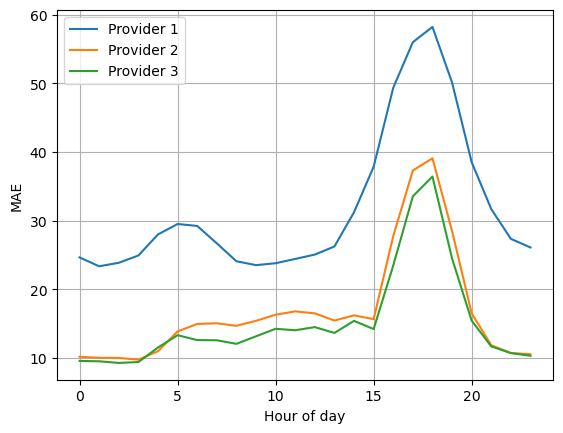

In [23]:
provider1_hour_mae = {}
provider2_hour_mae = {}
provider3_hour_mae = {}

for i in range(24):

    provider1_hour_mae[i] = abs(all_countries [ all_countries['hour'] == i]['Provider 1'] - all_countries [ all_countries['hour'] == i]['True value']).mean()
    provider2_hour_mae[i] = abs(all_countries [ all_countries['hour'] == i]['Provider 2'] - all_countries [ all_countries['hour'] == i]['True value']).mean()
    provider3_hour_mae[i] = abs(all_countries [ all_countries['hour'] == i]['Provider 3'] - all_countries [ all_countries['hour'] == i]['True value']).mean()


mae_per_hour_provider1 = pd.Series(provider1_hour_mae)
mae_per_hour_provider1.index.name = 'hour'

mae_per_hour_provider2 = pd.Series(provider2_hour_mae)
mae_per_hour_provider2.index.name = 'hour'

mae_per_hour_provider3 = pd.Series(provider3_hour_mae)
mae_per_hour_provider3.index.name = 'hour'

mae_per_hour_provider1.plot(label='Provider 1')
mae_per_hour_provider2.plot(label='Provider 2')
mae_per_hour_provider3.plot(label='Provider 3')
plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('MAE')
plt.grid()


In [24]:
mae_per_hour = pd.DataFrame({
    'Provider 1': provider1_hour_mae,
    'Provider 2': provider2_hour_mae,
    'Provider 3': provider3_hour_mae
})
mae_per_hour.index.name = 'hour'

### Day of week

In [25]:
dow_mean = all_countries.groupby('dayofweek').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
dow_mean

,Provider 1,Provider 2,Provider 3,True value
dayofweek,,,,
1,120.477506,95.709574,93.142544,101.055845
2,127.244452,99.468461,94.718477,100.713833
3,127.536595,101.689033,96.471011,103.282420
4,125.045932,102.834167,94.963500,102.282289
5,120.798848,102.227881,91.358544,97.864446
6,99.872315,84.878839,77.122629,82.385473
7,87.552721,77.939265,67.506883,70.726100


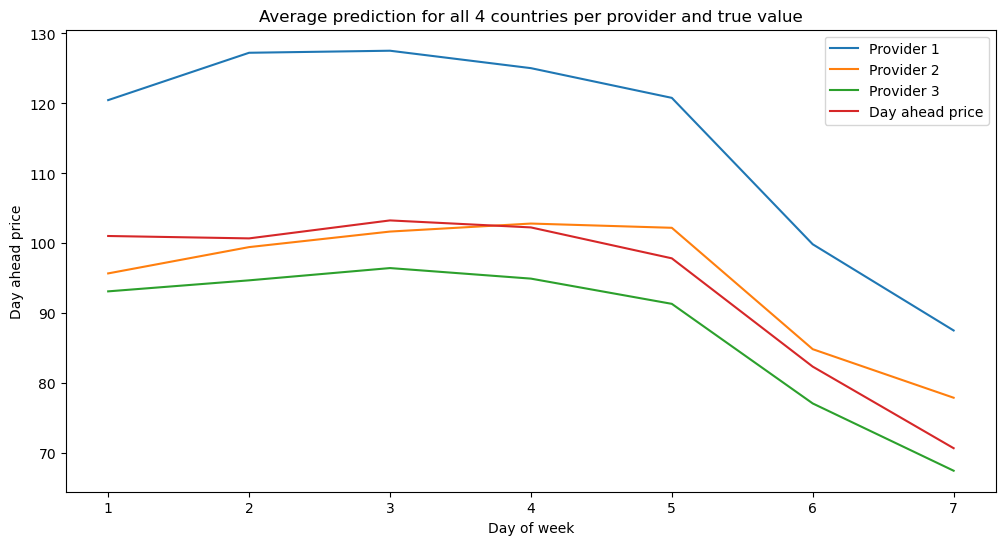

In [26]:
plt.figure(figsize=(12,6))

plt.plot(dow_mean['Provider 1'],label='Provider 1')
plt.plot(dow_mean['Provider 2'],label='Provider 2')
plt.plot(dow_mean['Provider 3'],label='Provider 3')
plt.plot(dow_mean['True value'],label='Day ahead price')
plt.title('Average prediction for all 4 countries per provider and true value')
plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Day ahead price');

In [27]:
print(f" Provider 1 MAE on day of week average {mean_absolute_error(dow_mean['Provider 1'],dow_mean['True value']):.2f}")
print(f" Provider 2 MAE on day of week average {mean_absolute_error(dow_mean['Provider 2'],dow_mean['True value']):.2f}")
print(f" Provider 3 MAE on day of week average {mean_absolute_error(dow_mean['Provider 3'],dow_mean['True value']):.2f}")

 Provider 1 MAE on day of week average 21.46
 Provider 2 MAE on day of week average 3.26
 Provider 3 MAE on day of week average 6.15


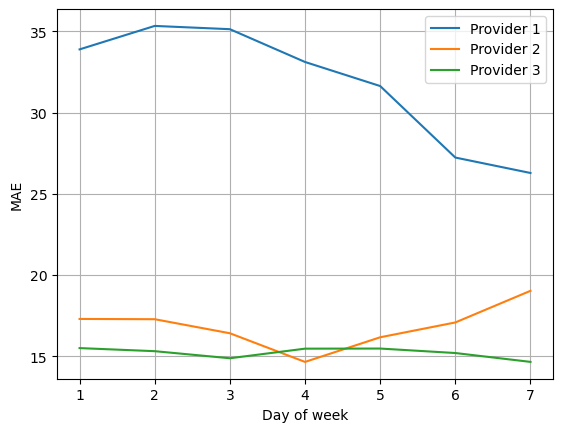

In [28]:
provider_1_dow_mae = {}
provider_2_dow_mae = {}
provider_3_dow_mae = {}

for i in range(1,8):

    provider_1_dow_mae[i] = abs(all_countries [ all_countries['dayofweek'] == i ]['Provider 1'] - all_countries [ all_countries['dayofweek'] == i ]['True value'] ).mean()
    provider_2_dow_mae[i] = abs(all_countries [ all_countries['dayofweek'] == i ]['Provider 2'] - all_countries [ all_countries['dayofweek'] == i ]['True value'] ).mean()
    provider_3_dow_mae[i] = abs(all_countries [ all_countries['dayofweek'] == i ]['Provider 3'] - all_countries [ all_countries['dayofweek'] == i ]['True value'] ).mean()

provider_1_dow_mae = pd.Series(provider_1_dow_mae)
provider_1_dow_mae.index.name = 'dayofweek'

provider_2_dow_mae = pd.Series(provider_2_dow_mae)
provider_2_dow_mae.index.name = 'dayofweek'

provider_3_dow_mae = pd.Series(provider_3_dow_mae)
provider_3_dow_mae.index.name = 'dayofweek'

provider_1_dow_mae.plot(label='Provider 1')
provider_2_dow_mae.plot(label='Provider 2')
provider_3_dow_mae.plot(label='Provider 3')
plt.xlabel('Day of week')
plt.ylabel('MAE');
plt.legend()
plt.grid()

In [29]:
mae_per_dayofweek = pd.DataFrame({
    'Provider 1': provider_1_dow_mae,
    'Provider 2': provider_2_dow_mae,
    'Provider 3': provider_3_dow_mae
})
mae_per_dayofweek.index.name = 'dow'

In [30]:
mae_per_dayofweek

,Provider 1,Provider 2,Provider 3
dow,,,
1,33.885381,17.293985,15.499684
2,35.330208,17.277259,15.309763
3,35.129134,16.412714,14.874652
4,33.110560,14.648449,15.465035
5,31.629205,16.165274,15.471590
6,27.228235,17.078205,15.195949
7,26.277718,19.025260,14.650743


### Month

In [31]:
months_mean = all_countries.groupby('month').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
months_mean

,Provider 1,Provider 2,Provider 3,True value
month,,,,
1,116.547507,90.464714,85.109555,92.317960
2,95.105485,76.464795,72.208558,74.918520
3,85.466899,71.518152,70.270907,70.315897
4,79.677809,63.858576,66.165329,66.197205
5,102.819157,84.190447,79.612300,84.817379
6,124.690983,103.569424,91.261958,100.145090
7,162.453001,140.141999,116.836004,133.752453
8,155.997870,128.132893,120.769682,128.707026


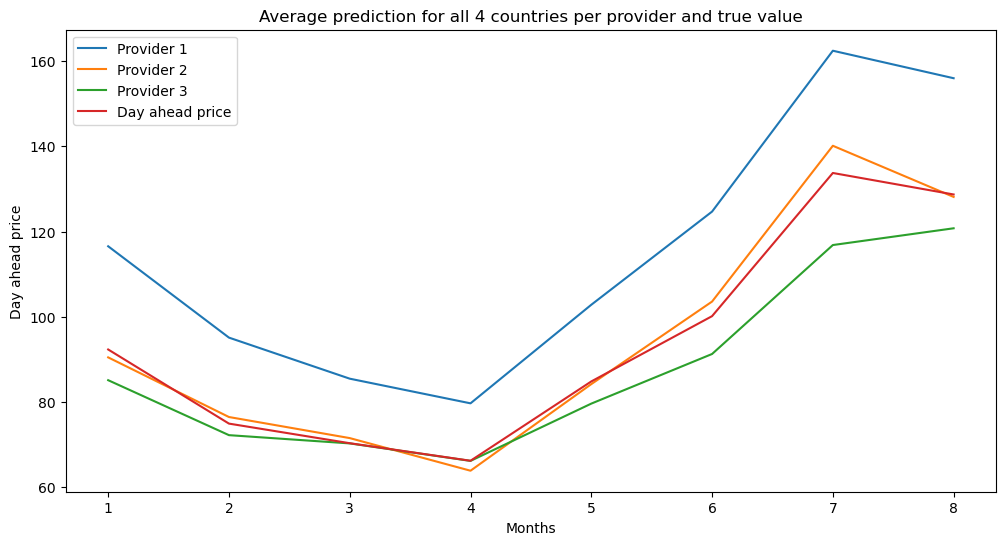

In [32]:
plt.figure(figsize=(12,6))

plt.plot(months_mean['Provider 1'],label='Provider 1')
plt.plot(months_mean['Provider 2'],label='Provider 2')
plt.plot(months_mean['Provider 3'],label='Provider 3')
plt.plot(months_mean['True value'],label='Day ahead price')
plt.title('Average prediction for all 4 countries per provider and true value')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Day ahead price');

In [33]:
print(f" Provider 1 MAE on month average {mean_absolute_error(months_mean['Provider 1'],months_mean['True value']):.2f}")
print(f" Provider 2 MAE on month average {mean_absolute_error(months_mean['Provider 2'],months_mean['True value']):.2f}")
print(f" Provider 3 MAE on month average {mean_absolute_error(months_mean['Provider 3'],months_mean['True value']):.2f}")

 Provider 1 MAE on month average 21.45
 Provider 2 MAE on month average 2.24
 Provider 3 MAE on month average 6.12


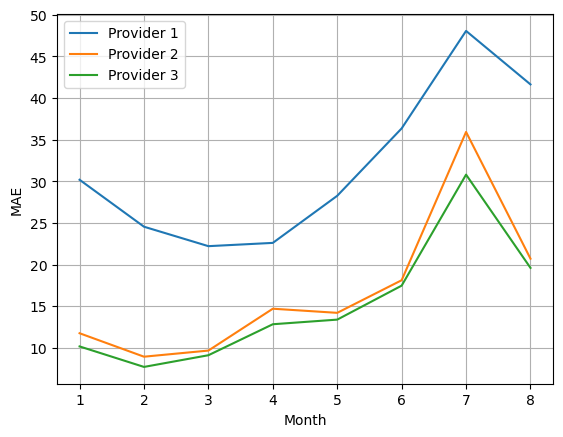

In [34]:
provider_1_month_mae = {}
provider_2_month_mae = {}
provider_3_month_mae = {}

for i in range(1,9):

    provider_1_month_mae[i] = abs(all_countries [ all_countries['month'] == i ]['Provider 1'] - all_countries [ all_countries['month'] == i ]['True value'] ).mean()
    provider_2_month_mae[i] = abs(all_countries [ all_countries['month'] == i ]['Provider 2'] - all_countries [ all_countries['month'] == i ]['True value'] ).mean()
    provider_3_month_mae[i] = abs(all_countries [ all_countries['month'] == i ]['Provider 3'] - all_countries [ all_countries['month'] == i ]['True value'] ).mean()

provider_1_month_mae = pd.Series(provider_1_month_mae)
provider_1_month_mae.index.name = 'month'

provider_2_month_mae = pd.Series(provider_2_month_mae)
provider_2_month_mae.index.name = 'month'

provider_3_month_mae = pd.Series(provider_3_month_mae)
provider_3_month_mae.index.name = 'month'

provider_1_month_mae.plot(label='Provider 1')
provider_2_month_mae.plot(label='Provider 2')
provider_3_month_mae.plot(label='Provider 3')
plt.xlabel('Month')
plt.ylabel('MAE');
plt.legend()
plt.grid()

In [35]:
mae_per_month = pd.DataFrame({
    'Provider 1': provider_1_month_mae,
    'Provider 2': provider_2_month_mae,
    'Provider 3': provider_3_month_mae
})
mae_per_month.index.name = 'month'

In [36]:
mae_per_month

,Provider 1,Provider 2,Provider 3
month,,,
1,30.197006,11.769079,10.186073
2,24.560090,8.952978,7.725073
3,22.224603,9.688216,9.129302
4,22.617681,14.713865,12.849625
5,28.273679,14.218585,13.404539
6,36.362733,18.134194,17.484755
7,48.068915,35.937772,30.813072
8,41.646529,20.723017,19.617023


### Quarter

In [37]:
quarter_mean = all_countries.groupby('quarter').mean(numeric_only=True)[['Provider 1','Provider 2','Provider 3','True value']]
quarter_mean

,Provider 1,Provider 2,Provider 3,True value
quarter,,,,
1,94.304462,75.658721,73.519028,76.034734
2,136.586181,114.093563,102.208263,111.950694


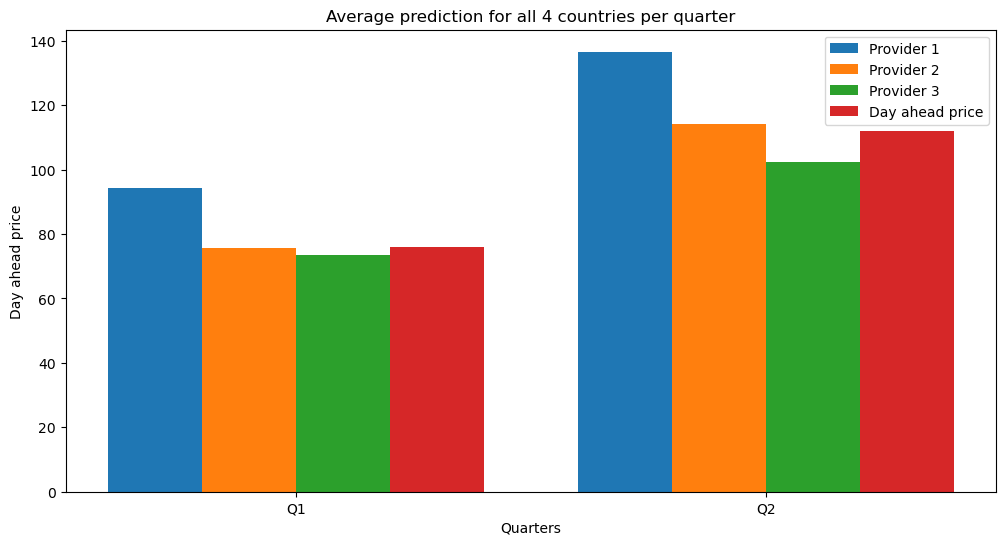

In [38]:
plt.figure(figsize=(12,6))

# Define the number of groups (quarters) and the width of each bar
quarters = ['Q1', 'Q2']  # Example quarters, replace with your data
bar_width = 0.2  # Width of each bar, reduced to fit all bars
index = np.arange(len(quarters))  # Location for each group of bars

# Plotting each provider's data
plt.bar(index, quarter_mean['Provider 1'], bar_width, label='Provider 1')
plt.bar(index + bar_width, quarter_mean['Provider 2'], bar_width, label='Provider 2')
plt.bar(index + 2 * bar_width, quarter_mean['Provider 3'], bar_width, label='Provider 3')
plt.bar(index + 3 * bar_width, quarter_mean['True value'], bar_width, label='Day ahead price')

# Add title and labels
plt.title('Average prediction for all 4 countries per quarter')
plt.xlabel('Quarters')
plt.ylabel('Day ahead price')

# Add ticks and legend
plt.xticks(index + 1.5 * bar_width, quarters)  # Adjusting ticks to be centered
plt.legend()

plt.show()

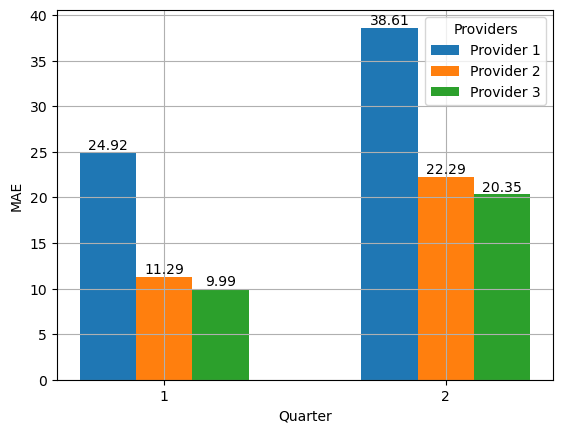

In [39]:
provider_1_quarter_mae = {}
provider_2_quarter_mae = {}
provider_3_quarter_mae = {}

for i in range(1,3):

    provider_1_quarter_mae[i] = abs(all_countries [ all_countries['quarter'] == i ]['Provider 1'] - all_countries [ all_countries['quarter'] == i ]['True value'] ).mean()
    provider_2_quarter_mae[i] = abs(all_countries [ all_countries['quarter'] == i ]['Provider 2'] - all_countries [ all_countries['quarter'] == i ]['True value'] ).mean()
    provider_3_quarter_mae[i] = abs(all_countries [ all_countries['quarter'] == i ]['Provider 3'] - all_countries [ all_countries['quarter'] == i ]['True value'] ).mean()

provider_1_quarter_mae = pd.Series(provider_1_quarter_mae)
provider_1_quarter_mae.index.name = 'quarter'

provider_2_quarter_mae = pd.Series(provider_2_quarter_mae)
provider_2_quarter_mae.index.name = 'quarter'

provider_3_quarter_mae = pd.Series(provider_3_quarter_mae)
provider_3_quarter_mae.index.name = 'quarter'

mae_per_quarter = pd.DataFrame({
    'Provider 1': provider_1_quarter_mae,
    'Provider 2': provider_2_quarter_mae,
    'Provider 3': provider_3_quarter_mae
})
mae_per_quarter.index.name = 'quarter'

n_quarters = len(mae_per_quarter)

# Ορισμός θέσης των bars
bar_width = 0.2  # Πλάτος των bars
quarters = np.arange(n_quarters)  # Οι θέσεις των bars για το κάθε quarter

# Δημιουργία grouped bar plot
bars1 = plt.bar(quarters - bar_width, mae_per_quarter['Provider 1'], width=bar_width, label='Provider 1')
bars2 = plt.bar(quarters, mae_per_quarter['Provider 2'], width=bar_width, label='Provider 2')
bars3 = plt.bar(quarters + bar_width, mae_per_quarter['Provider 3'], width=bar_width, label='Provider 3')

# Προσθήκη τιμών πάνω από τα bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Προσθήκη τίτλων στους άξονες
plt.xlabel('Quarter')
plt.ylabel('MAE')
plt.xticks(quarters, mae_per_quarter.index)  # Προσθήκη των labels για τα quarters

# Προσθήκη υπομνήματος (legend)
plt.legend(title='Providers')

# Προσθήκη πλέγματος
plt.grid(True)

# Εμφάνιση του γραφήματος
plt.show()

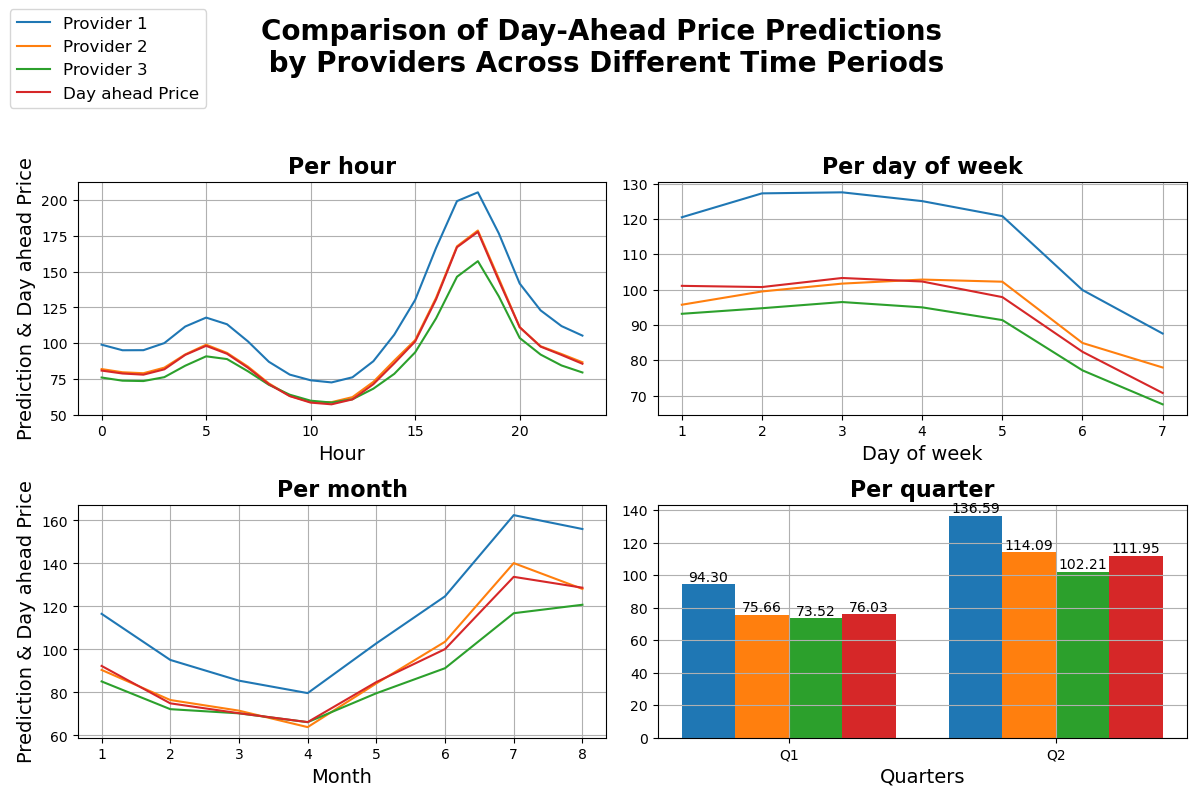

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

#axes[0][0].plot(all_countries_clean_month['True value'])
line1, = axes[0][0].plot(hours_mean['Provider 1'], label='Provider 1')
line2, = axes[0][0].plot(hours_mean['Provider 2'], label='Provider 2')
line3, = axes[0][0].plot(hours_mean['Provider 3'], label='Provider 3')
line4, = axes[0][0].plot(hours_mean['True value'], label='Day ahead Price')
axes[0][0].set_title('Per hour', **title_font)
axes[0][0].set_xlabel('Hour', **label_font)
axes[0][0].set_ylabel('Prediction & Day ahead Price', **label_font)
axes[0][0].grid(True)

quarters = ['Q1', 'Q2']  # Example quarters, replace with your actual data
bar_width = 0.2  # Width of each bar
index = np.arange(len(quarters))  # Location for each group of bars

bar1 = axes[1][1].bar(index, quarter_mean['Provider 1'][:2], bar_width, label='Provider 1')  # Only the first 2 values for Q1, Q2
bar2 = axes[1][1].bar(index + bar_width, quarter_mean['Provider 2'][:2], bar_width, label='Provider 2')
bar3 = axes[1][1].bar(index + 2 * bar_width, quarter_mean['Provider 3'][:2], bar_width, label='Provider 3')
bar4 = axes[1][1].bar(index + 3 * bar_width, quarter_mean['True value'][:2], bar_width, label='Day ahead Price')

# Set title, labels, and grid for axes[1][1]
axes[1][1].set_title('Per quarter', **title_font)
axes[1][1].set_xlabel('Quarters', **label_font)
axes[1][1].set_xticks(index + 1.5 * bar_width)
axes[1][1].set_xticklabels(quarters)  # Set the quarter labels (Q1, Q2)
axes[1][1].grid(True)

# Add the values on top of the bars
for bar in bar1:
    height = bar.get_height()
    axes[1][1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bar2:
    height = bar.get_height()
    axes[1][1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bar3:
    height = bar.get_height()
    axes[1][1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bar4:
    height = bar.get_height()
    axes[1][1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

line5, = axes[1][0].plot(months_mean['Provider 1'], label='Provider 1')
line6, = axes[1][0].plot(months_mean['Provider 2'], label='Provider 2')
line7, = axes[1][0].plot(months_mean['Provider 3'], label='Provider 3')
line8, = axes[1][0].plot(months_mean['True value'], label='Day ahead Price')

axes[1][0].set_title('Per month', **title_font)
axes[1][0].set_xlabel('Month', **label_font)
axes[1][0].set_ylabel('Prediction & Day ahead Price', **label_font)
axes[1][0].grid(True)

line9, = axes[0][1].plot(dow_mean['Provider 1'], label='Provider 1')
line10, = axes[0][1].plot(dow_mean['Provider 2'], label='Provider 2')
line11, = axes[0][1].plot(dow_mean['Provider 3'], label='Provider 3')
line12, = axes[0][1].plot(dow_mean['True value'], label='Day ahead Price')

axes[0][1].set_title('Per day of week', **title_font)
axes[0][1].set_xlabel('Day of week', **label_font)
axes[0][1].grid(True)

# Collect all lines and labels from all plots
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]

# Create a single legend for all axes and place it in the upper left corner
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 1), ncol=1, fontsize=12)

fig.suptitle('Comparison of Day-Ahead Price Predictions\n by Providers Across Different Time Periods', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.92])

#plt.savefig('day_ahead_comparisson.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα

# Εμφάνιση του γραφήματος
plt.show()

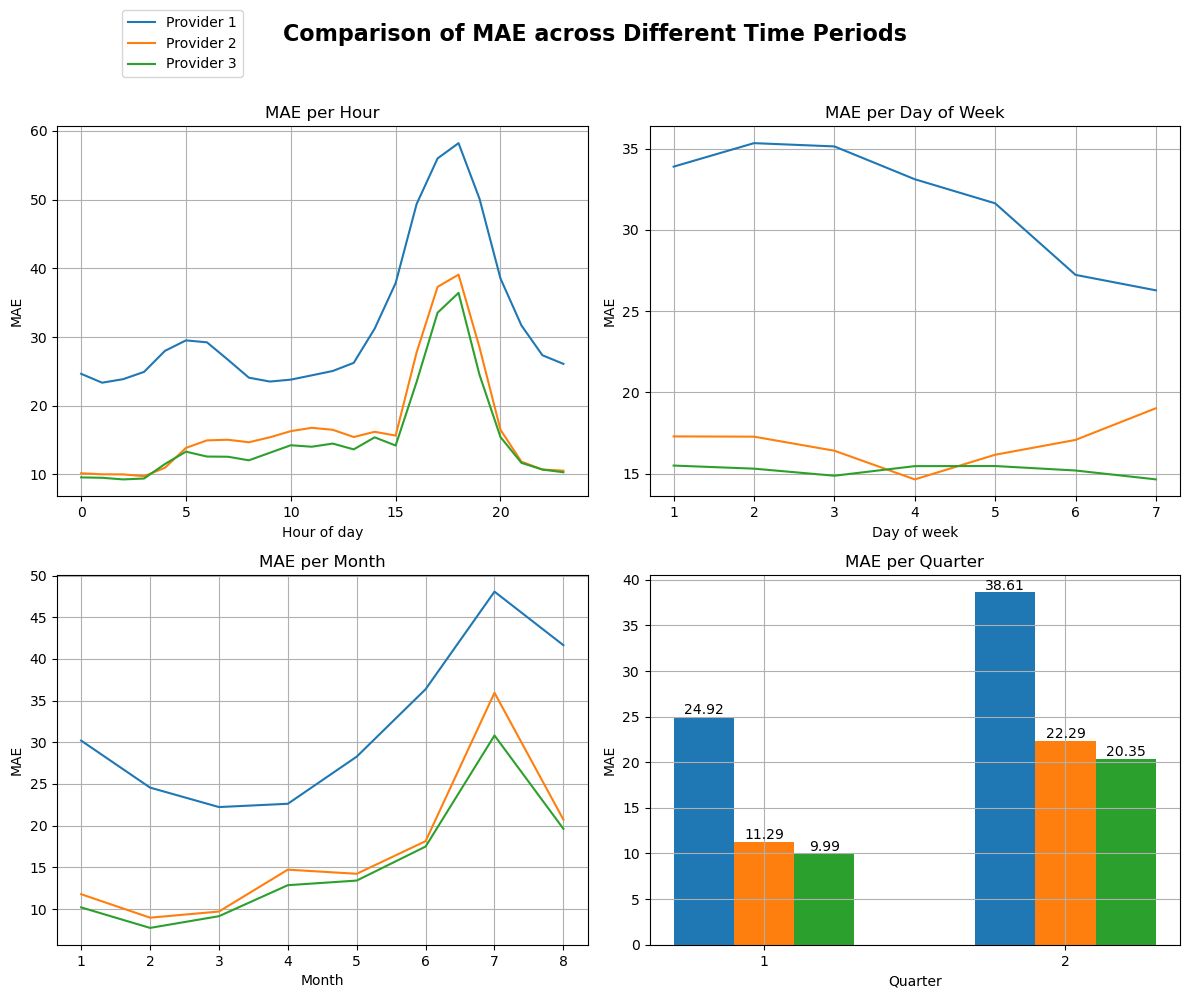

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

#MAE per hour
    
axes[0, 0].plot(mae_per_hour['Provider 1'], label='Provider 1')
axes[0, 0].plot(mae_per_hour['Provider 2'], label='Provider 2')
axes[0, 0].plot(mae_per_hour['Provider 3'], label='Provider 3')
axes[0, 0].set_title('MAE per Hour')
axes[0, 0].set_xlabel('Hour of day')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# 2. MAE per day of week

axes[0, 1].plot(mae_per_dayofweek['Provider 1'], label='Provider 1')
axes[0, 1].plot(mae_per_dayofweek['Provider 2'], label='Provider 2')
axes[0, 1].plot(mae_per_dayofweek['Provider 3'], label='Provider 3')
axes[0, 1].set_title('MAE per Day of Week')
axes[0, 1].set_xlabel('Day of week')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True)

# 3. MAE per month
axes[1, 0].plot(mae_per_month['Provider 1'], label='Provider 1')
axes[1, 0].plot(mae_per_month['Provider 2'], label='Provider 2')
axes[1, 0].plot(mae_per_month['Provider 3'], label='Provider 3')
axes[1, 0].set_title('MAE per Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(True)

# 4. MAE per quarter (bar chart)
bar_width = 0.2
index = np.arange(len(mae_per_quarter.index))
bars1 = axes[1, 1].bar(index, mae_per_quarter['Provider 1'], bar_width, label='Provider 1')
bars2 = axes[1, 1].bar(index + bar_width, mae_per_quarter['Provider 2'], bar_width, label='Provider 2')
bars3 = axes[1, 1].bar(index + 2 * bar_width, mae_per_quarter['Provider 3'], bar_width, label='Provider 3')

axes[1, 1].set_title('MAE per Quarter')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_xticks(index + bar_width)
axes[1, 1].set_xticklabels(mae_per_quarter.index)
axes[1, 1].grid(True)

# Προσθήκη των τιμών πάνω από κάθε bar
for bar in bars1:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in bars3:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Τοποθέτηση του legend πάνω αριστερά
fig.legend(['Provider 1','Provider 2','Provider 3'], loc='upper left', bbox_to_anchor=(0.1, 1), ncol=1)

# Προσθήκη κεντρικού τίτλου
fig.suptitle('Comparison of MAE across Different Time Periods', fontsize=16, fontweight='bold')

# Προσαρμογή layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## EDA for day ahead price

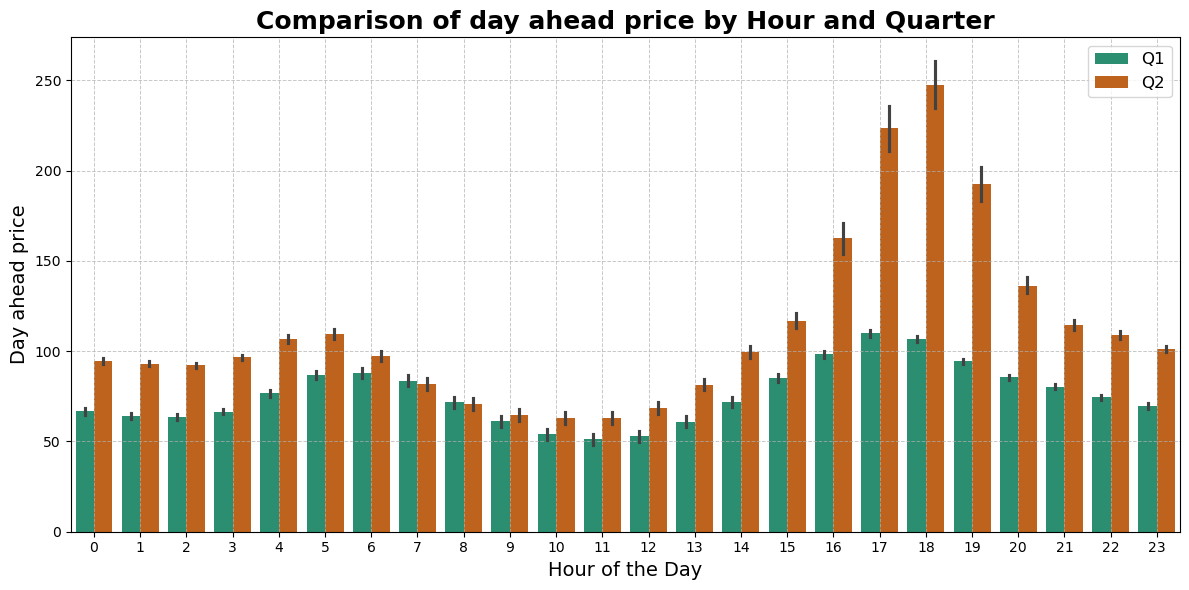

In [42]:
plt.figure(figsize=(12,6))

ax = sns.barplot(data=all_countries, x='hour', y='True value', hue='quarter', palette='Dark2')

plt.title('Comparison of day ahead price by Hour and Quarter', fontsize=18, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Day ahead price', fontsize=14)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Q1', 'Q2'], fontsize=12, title_fontsize=14)

ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()

#plt.savefig('day_ahead_price_comparison_of_day_ahead_price_by_hour_quarter.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα

plt.show()

C:\Users\dimit\AppData\Local\Temp\ipykernel_22692\1730470751.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_countries, x='hour', y='True value', palette='coolwarm', alpha=0.85, errorbar='sd')


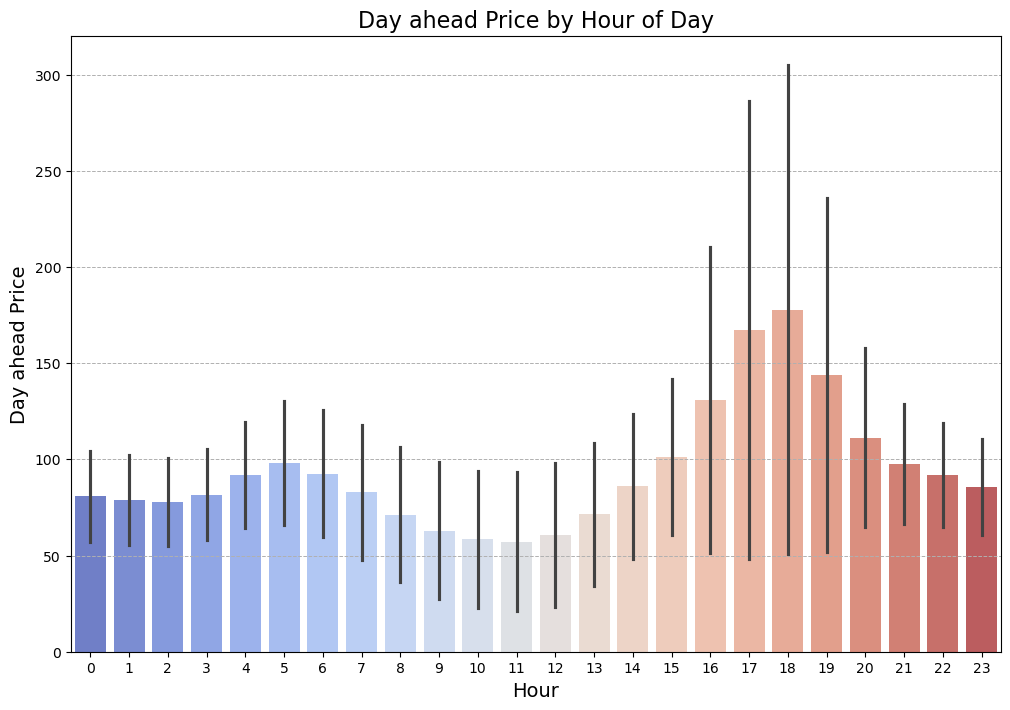

In [43]:
plt.figure(figsize=(12,8))

# Customize color palette and transparency
sns.barplot(data=all_countries, x='hour', y='True value', palette='coolwarm', alpha=0.85, errorbar='sd')

# Add enhancements
plt.title('Day ahead Price by Hour of Day', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Day ahead Price', fontsize=14)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

#plt.savefig('day_ahead_price_by_hour_of_day.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα


# Show the modified plot
plt.show()

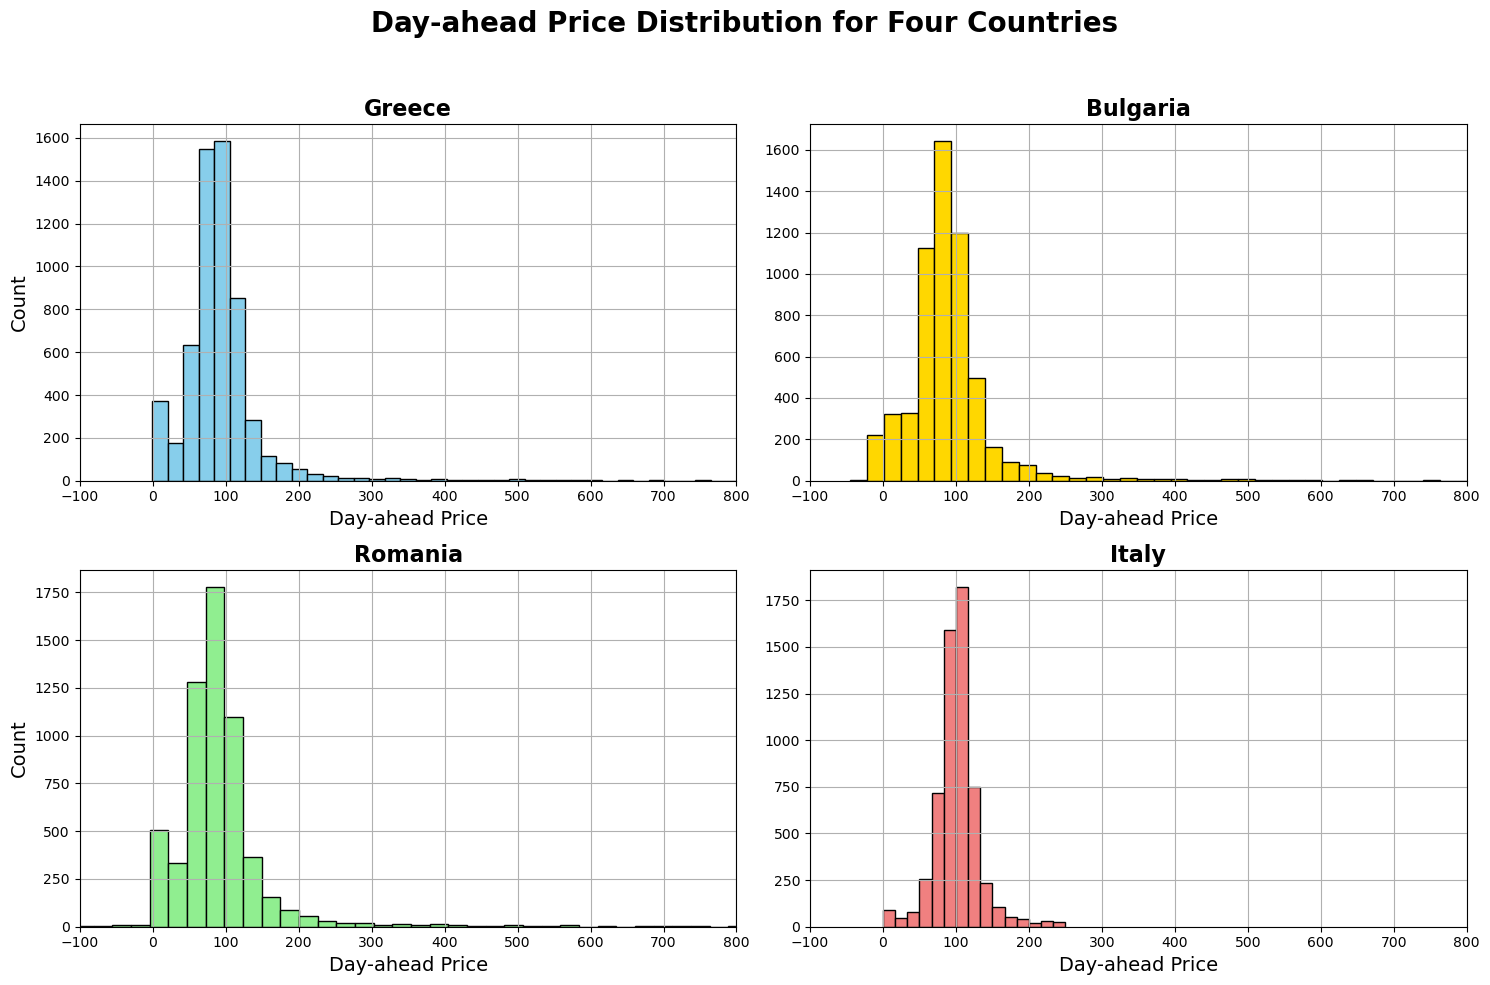

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Στυλ γραμματοσειράς
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14}

# Histogram για την Ελλάδα
axes[0][0].hist(greece['True value'], bins=40, edgecolor='black', color='skyblue')
axes[0][0].set_title('Greece', **title_font)
axes[0][0].set_xlabel('Day-ahead Price', **label_font)
axes[0][0].set_ylabel('Count', **label_font)
axes[0][0].set_xlim(-100, 800)
axes[0][0].grid(True)

# Histogram για την Ιταλία
axes[1][1].hist(italy['True value'], bins=15, edgecolor='black', color='lightcoral')
axes[1][1].set_title('Italy', **title_font)
axes[1][1].set_xlabel('Day-ahead Price', **label_font)
#axes[1][1].set_ylabel('Count', **label_font)
axes[1][1].set_xlim(-100, 800)
axes[1][1].grid(True)

# Histogram για τη Ρουμανία
axes[1][0].hist(romania['True value'], bins=40, edgecolor='black', color='lightgreen')
axes[1][0].set_title('Romania', **title_font)
axes[1][0].set_xlabel('Day-ahead Price', **label_font)
axes[1][0].set_ylabel('Count', **label_font)
axes[1][0].set_xlim(-100, 800)
axes[1][0].grid(True)

# Histogram για τη Βουλγαρία
axes[0][1].hist(bulgaria['True value'], bins=40, edgecolor='black', color='gold')
axes[0][1].set_title('Bulgaria', **title_font)
axes[0][1].set_xlabel('Day-ahead Price', **label_font)
#axes[0][1].set_ylabel('Count', **label_font)
axes[0][1].set_xlim(-100, 800)
axes[0][1].grid(True)

# Προσαρμογή του layout

fig.suptitle('Day-ahead Price Distribution for Four Countries', fontsize=20, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig('day_ahead_price_distribution.jpg', format='jpg', dpi=300)  # dpi 300 για καλή ποιότητα


# Εμφάνιση του γραφήματος
plt.show()

In [45]:
all_countries.corr()['True value'].sort_values()[5:-1].round(2)

Provider 1    0.76
Provider 2    0.84
Provider 3    0.88
Name: True value, dtype: float64

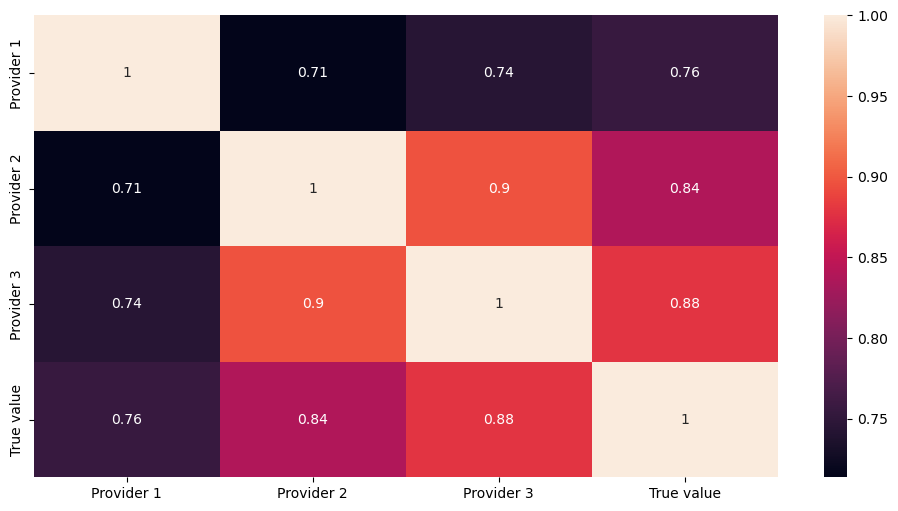

In [46]:
plt.figure(figsize=(12,6))
sns.heatmap(data=all_countries[['Provider 1','Provider 2','Provider 3','True value']].corr(),annot=True);

## Calculating MAE

In [47]:
mae_greece1 = mean_absolute_error(greece['Provider 1'], greece['True value'])
mae_bulgaria1 = mean_absolute_error(bulgaria['Provider 1'], bulgaria['True value'])
mae_romania1 = mean_absolute_error(romania['Provider 1'], romania['True value'])
mae_italy1 = mean_absolute_error(italy['Provider 1'], italy['True value'])

mae_greece2 = mean_absolute_error(greece['Provider 2'], greece['True value'])
mae_bulgaria2 = mean_absolute_error(bulgaria['Provider 2'], bulgaria['True value'])
mae_romania2 = mean_absolute_error(romania['Provider 2'], romania['True value'])
mae_italy2 = mean_absolute_error(italy['Provider 2'], italy['True value'])


mae_greece3 = mean_absolute_error(greece['Provider 3'], greece['True value'])
mae_bulgaria3 = mean_absolute_error(bulgaria['Provider 3'], bulgaria['True value'])
mae_romania3 = mean_absolute_error(romania['Provider 3'], romania['True value'])
mae_italy3 = mean_absolute_error(italy['Provider 3'], italy['True value'])


print(f"Mean Absolute Error (MAE) for PV1 Greece: {mae_greece1:.2f}")
print(f"Mean Absolute Error (MAE) for PV1 Bulgaria: {mae_bulgaria1:.2f}")
print(f"Mean Absolute Error (MAE) for PV1 Romania: {mae_romania1:.2f}")
print(f"Mean Absolute Error (MAE) for PV1 Italy: {mae_italy1:.2f}")

print('\n')

print(f"Mean Absolute Error (MAE) for PV2 Greece: {mae_greece2:.2f}")
print(f"Mean Absolute Error (MAE) for PV2 Bulgaria: {mae_bulgaria2:.2f}")
print(f"Mean Absolute Error (MAE) for PV2 Romania: {mae_romania2:.2f}")
print(f"Mean Absolute Error (MAE) for PV2 Italy: {mae_italy2:.2f}")

print('\n')

print(f"Mean Absolute Error (MAE) for PV3 Greece: {mae_greece3:.2f}")
print(f"Mean Absolute Error (MAE) for PV3 Bulgaria: {mae_bulgaria3:.2f}")
print(f"Mean Absolute Error (MAE) for PV3 Romania: {mae_romania3:.2f}")
print(f"Mean Absolute Error (MAE) for PV3 Italy: {mae_italy3:.2f}")

Mean Absolute Error (MAE) for PV1 Greece: 15.00
Mean Absolute Error (MAE) for PV1 Bulgaria: 86.48
Mean Absolute Error (MAE) for PV1 Romania: 16.97
Mean Absolute Error (MAE) for PV1 Italy: 8.84


Mean Absolute Error (MAE) for PV2 Greece: 17.32
Mean Absolute Error (MAE) for PV2 Bulgaria: 19.49
Mean Absolute Error (MAE) for PV2 Romania: 21.20
Mean Absolute Error (MAE) for PV2 Italy: 9.33


Mean Absolute Error (MAE) for PV3 Greece: 15.69
Mean Absolute Error (MAE) for PV3 Bulgaria: 17.35
Mean Absolute Error (MAE) for PV3 Romania: 18.30
Mean Absolute Error (MAE) for PV3 Italy: 9.51


In [48]:
mae_provider1 = mean_absolute_error(all_countries['Provider 1'], all_countries['True value'])
mae_provider2 = mean_absolute_error(all_countries['Provider 2'], all_countries['True value'])
mae_provider3 = mean_absolute_error(all_countries['Provider 3'], all_countries['True value'])

print(f"Mean Absolute Error (MAE) for PV1: {mae_provider1:.2f}")
print(f"Mean Absolute Error (MAE) for PV2: {mae_provider2:.2f}")
print(f"Mean Absolute Error (MAE) for PV3: {mae_provider3:.2f}")

Mean Absolute Error (MAE) for PV1: 31.82
Mean Absolute Error (MAE) for PV2: 16.83
Mean Absolute Error (MAE) for PV3: 15.21


In [49]:
rmse_provider1 = np.sqrt(mean_squared_error(all_countries['Provider 1'], all_countries['True value']))
rmse_provider2 = np.sqrt(mean_squared_error(all_countries['Provider 2'], all_countries['True value']))
rmse_provider3 = np.sqrt(mean_squared_error(all_countries['Provider 3'], all_countries['True value']))

print(f"Root Mean Squared Error (MAE) for PV1: {rmse_provider1:.2f}")
print(f"Root Mean Squared Error (MAE) for PV2: {rmse_provider2:.2f}")
print(f"Root Mean Squared Error (MAE) for PV3: {rmse_provider3:.2f}")

Root Mean Squared Error (MAE) for PV1: 57.57
Root Mean Squared Error (MAE) for PV2: 34.69
Root Mean Squared Error (MAE) for PV3: 30.25


## Random graphs

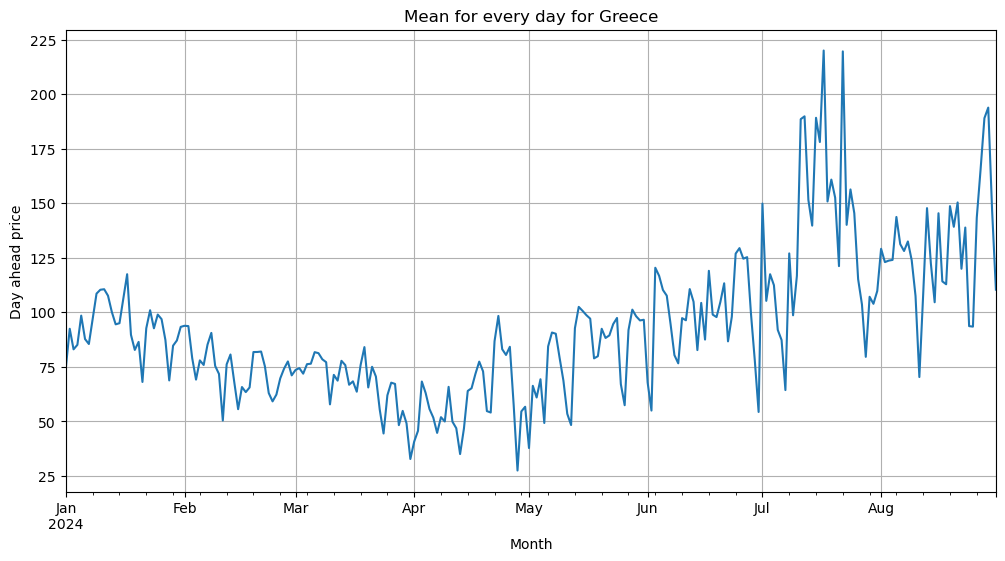

In [57]:
plt.figure(figsize=(12,6))
greece.resample(rule='D').mean()['True value'].plot()
plt.xlabel('Month')
plt.ylabel('Day ahead price')
plt.title('Mean for every day for Greece')
plt.grid()